In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<pre>
** 전처리 마지막 시도
- wma14 * 1.2 적용하기
- 0인걸 제외하고 wma 계산되도록 개선(보류)
- 타겟값 wma14로 스무싱 하고 bfill
- rolling(3), rolling(7) 넣기(보류)
- 다른 일반변수 컬럼들 0인값 채우기(가중치이동평균선 7로)
- 시계열에선 과대적합 되면 좋지 않을까??


이것도 안되면 그냥..모델링이 답인거같다.
결과 : 0.38


In [2]:
!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 9.3 MB/s 


In [3]:
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=76e49458326e7bda673cb12837870e93a97facdabedfc319c1525bf54ed73964
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
from glob import glob
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from pandasql import sqldf
from sklearn.preprocessing import StandardScaler
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings(action='ignore')
from matplotlib import font_manager, rc
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# font_path = "C:\\Windows\\Fonts\\\x7f\x7f\x7f\x7fBOLD.TTF"
# font = font_manager.FontProperties(fname=font_path).get_name()
# rc('font', family=font)
from sklearn.manifold import TSNE
import re
import talib as tb

In [5]:
def weather(주소,name = 'train'):
    t=0
    if name =='test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):
        globals()[f'{name}_weather_'+str(i)]=pd.DataFrame()

        for k in range(0,3):
            try:
                weather = pd.read_csv(주소+f'/weather_{i}_{t}.csv')
                if len(weather)==0:
                    weather = pd.read_csv(주소+f'/weather_0_0.csv')
                    weather=weather.set_index('datadate')
                    weather[weather.columns] = 0
                    weather=weather.reset_index()
                weather = weather.set_index('datadate')
                weather['습도(%)']=weather['습도(%)'].apply(lambda x : np.nan if x==' ' else x)
                weather['습도(%)']=weather['습도(%)'].astype('float')
                weather.columns = weather.columns+f'_{k%3}'
                globals()[f'{name}_weather_'+str(i)]=pd.merge(globals()[f'{name}_weather_'+str(i)],weather,how='right',left_index=True, right_index=True)    


            except:
                break
            t+=1



        globals()[f'{name}_weather_'+str(i)]=globals()[f'{name}_weather_'+str(i)].reset_index()
        cols = globals()[f'{name}_weather_'+str(i)].columns
        globals()[f'{name}_weather_'+str(i)]['월일']=globals()[f'{name}_weather_'+str(i)]['datadate']%10000
       

        
        if name == 'train':
            qwe =  globals()[f'{name}_weather_'+str(i)].groupby('월일').mean().reset_index()
            qwe.columns = qwe.columns+'_평균'
            globals()[f'train_weather_평균_'+str(i)]= qwe



            


        globals()[f'{name}_weather_'+str(i)] = pd.merge(globals()[f'{name}_weather_'+str(i)],globals()[f'train_weather_평균_'+str(i)],how='left',left_on = '월일',right_on='월일_평균')
        for c in cols:
            globals()[f'{name}_weather_'+str(i)][c]=globals()[f'{name}_weather_'+str(i)].apply(lambda x: x[c] if np.isnan(x[c]) == False else (0 if np.isnan(x[c+'_평균']) else x[c+'_평균']),axis=1)
                
    
        
        
        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_weather_'+str(i)] = globals()[f'{name}_weather_'+str(i)][cols]

        else:
            globals()[f'{name}_weather_'+str(i)] = globals()[f'{name}_weather_'+str(i)][cols]

        

In [6]:
def add_dosomae(주소,name='train', option=1):
        if name == 'test':
            test_dir = 주소.split('/')[-2][-1]
        data_list = glob(주소+'*') # train raw 데이터 넣을지 / test raw 데이터 넣을지 경로
        domae = []
        somae = []

        for i in data_list:
            if 'domae' in i:
                domae.append(i)
            if 'somae' in i:
                somae.append(i)
        
        sum_df = pd.DataFrame()
                
        if option == 1:
            df = domae
            text = 'domae'
        else:
            df = somae
            text = 'somae'


        for i in tqdm(df):
            test = pd.read_csv(i)
            
            k=i.split('/')[-1].split("_")[1].split(".")[0]
            test.fillna(0,inplace=True) # 널값 0으로 채워주고
            if len(test)==0:
                test = pd.read_csv(주소+f'/domae_0.csv')
                test=test.set_index('datadate')
                test[test.columns] = 0
                test=test.reset_index()
                

            
            test['조사단위(kg)'] = test['조사단위(kg)'].replace('g$|kg$|개|포기|접', '',regex=True)
            test=test.astype({'조사단위(kg)':'float'})
            test.loc[test['조사단위(kg)'] >= 100, '단위당가격'] = test['가격(원)']* test['조사단위(kg)'] /1000
            test.loc[test['조사단위(kg)'] < 100, '단위당가격'] = test['가격(원)']/ test['조사단위(kg)']
            
            sep = test.loc[(test['등급명'] == '상품') | (test['등급명'] == 'S과') | (test['등급명'] == 0)]   # 모든 상품에 대해서 수행하지 않고 GRAD_NM이 '상품', 'S과' 만 해당하는 품목 가져옴
            sep = sep[['datadate', '등급명', '조사단위(kg)', '가격(원)']]

            sep.rename(columns={"가격(원)": "가격"}, inplace=True)
            sep2 = sqldf(
                f"select datadate, max(가격) as '일자별_{text}가격_최대(원)', avg(가격) as '일자별_{text}가격_평균(원)', min(가격) as '일자별_{text}가격_최소(원)' from sep group by datadate")

            sep2.fillna(0,inplace=True)
#             if len(sep2) == 0:
#                 if name=='test':
#                     sep2 =  globals()['sep_'+test_dir+f'_{name}_{text}_0'] 
#                     sep2

#                 else:
#                     sep2 =  globals()[f'{name}_{text}_0'] 
#                     sep2[sep2.columns] = 0 
                
                
            if name=='test':
                globals()['sep_'+test_dir+f'_{name}_{text}_{k}'] = sep2
                
            else:
                globals()[f'{name}_{text}_{k}'] = sep2
 
                


        
                               
               
             

In [7]:
def pummok(주소,name='train'):
    if name == 'test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):

        try:
            pummok = pd.read_csv(주소+f'/pummok_{i}.csv')
            if len(pummok) == 0 :
                pummok = pd.read_csv(주소+f'/pummok_0.csv')
                pummok = pummok.groupby('datadate').mean()
                pummok = pummok[['단가(원)','거래량','해당일자_전체평균가격(원)']]
                pummok[pummok.columns] = 0
                pummok = pummok.reset_index()
                
            else:   
                pummok = pummok.groupby('datadate').mean()
                pummok = pummok[['단가(원)','거래량','해당일자_전체평균가격(원)']]

                # 새로 추가한 부분
                pummok['해당일자_전체평균가격(원)'].fillna(0, inplace=True)
                pummok['wma14'] =  tb.WMA(pummok['해당일자_전체평균가격(원)'], 14)
                pummok['wma14'].fillna(method='bfill', inplace=True)

                # wma * 1.2 적용  -> 그림이 제일 비슷하게 나온다.
                pummok['해당일자_전체평균가격(원)'] = np.where(pummok['해당일자_전체평균가격(원)']==0, pummok['wma14']*1.2, pummok['해당일자_전체평균가격(원)'])
                pummok.drop('wma14', axis=1, inplace=True)


                
                pummok = pummok.reset_index()
                pummok.fillna(0, inplace = True)
                # pummok.fillna(0,inplace = True)
                
                
                

        except:
            continue

        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_pummok_{i}'] = pummok

        else:
            globals()[f'{name}_pummok_{i}'] = pummok


In [8]:
def imexport(주소, name='train'):
    if name == 'test':
        test_dir = 주소.split('/')[-2][-1]
    for i in tqdm(range(0,37)):
        try:
            imexport=pd.read_csv(주소+f'/imexport_{i}.csv')
            
            if len(imexport) == 0:
                imexport = pd.read_csv(주소+f'/imexport_0.csv')
                imexport = imexport.groupby('datadate').mean()
                imexport[imexport.columns] = 0

            else:  
                imexport = imexport.groupby('datadate').mean()


        except:
            
            imexport = pd.read_csv(주소+f'/imexport_0.csv')
            imexport = imexport.groupby('datadate').mean()
            imexport[imexport.columns] = 0
            pass


        imexport.fillna(0,inplace=True)
        if name=='test':
            globals()['sep_'+test_dir+f'_{name}_imexport_{i}'] = imexport

        else:
            globals()[f'{name}_imexport_{i}'] = imexport


    
    

In [9]:
def make_csv(주소,name = 'train'):
    imexport(주소,name)
    pummok(주소,name)
    add_dosomae(주소,name)
    add_dosomae(주소,name,2)
    weather(주소,name)
    for i in range(0,37):
        if name == 'test':

            num = 주소.split('/')[-2][-1]
            
            
            temp = globals()[f'sep_{num}_{name}_pummok_{i}']

            temp1 = globals()[f'sep_{num}_{name}_weather_{i}']

            temp2 = globals()[f'sep_{num}_{name}_domae_{i}']
   
            temp3 = globals()[f'sep_{num}_{name}_somae_{i}']

            temp4 = globals()[f'sep_{num}_{name}_imexport_{i}']
            temp.set_index('datadate',inplace=True)
            temp1.set_index('datadate',inplace=True)
            temp2.set_index('datadate',inplace=True)
            temp3.set_index('datadate',inplace=True)

            temp = temp.join(temp1)
            temp = temp.join(temp2)
            temp = temp.join(temp3)
            temp.reset_index(inplace = True)
            temp['datadate'] = temp['datadate'].astype('str')
            temp['yyyymm'] =  temp['datadate'].apply(lambda x: x[:6] )
            temp4.reset_index(inplace=True)
            temp4['yyyymm'] = temp4['datadate'].astype('str')
            temp4.drop('datadate',inplace=True,axis=1)
            temp = temp.merge(temp4, how='left',on='yyyymm')
            temp.set_index('datadate',inplace = True)
            temp.drop('yyyymm',inplace=True,axis=1)

            temp.fillna(0, inplace=True)
            globals()[f'{name}_total_sep_{num}_{i}'] = temp


        else:
            temp = globals()[f'{name}_pummok_{i}']
            temp1 = globals()[f'{name}_weather_{i}']
            temp2 = globals()[f'{name}_domae_{i}']
            temp3 = globals()[f'{name}_somae_{i}']
            temp4 = globals()[f'{name}_imexport_{i}']
            temp.set_index('datadate',inplace=True)
            temp1.set_index('datadate',inplace=True)
            temp2.set_index('datadate',inplace=True)
            temp3.set_index('datadate',inplace=True)
            temp = temp.join(temp1)
            temp = temp.join(temp2)
            temp = temp.join(temp3)
            temp.reset_index(inplace = True)
            temp['datadate'] = temp['datadate'].astype('str')
            temp['yyyymm'] =  temp['datadate'].apply(lambda x: x[:6] )
            temp4.reset_index(inplace=True)
            temp4['yyyymm'] = temp4['datadate'].astype('str')
            temp4.drop('datadate',inplace=True,axis=1)
            temp = temp.merge(temp4, how='left',on='yyyymm')
            temp.set_index('datadate',inplace = True)
            temp.drop('yyyymm',inplace=True,axis=1)

            temp.fillna(0, inplace=True)
            globals()[f'{name}_total_{i}'] = temp
        
    

In [10]:
# train_data만들기 train_total_0 ~ train_total_36까지 만들어준다.
make_csv('/content/drive/MyDrive/농산물예측/aT_data/aT_train_raw/','train')

100%|██████████| 37/37 [00:16<00:00,  2.25it/s]


In [13]:
# wma 7일때 확인
for i in range(37):
  df= globals()[f'train_total_{i}']
  df['wma7'] = tb.WMA(df['해당일자_전체평균가격(원)'], 7)
  df['wma14'] = tb.WMA(df['해당일자_전체평균가격(원)'], 14)
  plt.figure(figsize=(14, 5))
  
  plt.plot(df['해당일자_전체평균가격(원)'], marker='+', color='g')
  plt.plot(df['wma7'],  marker='*', color='b')
  #plt.plot(df['wma14'],  marker='s', color='yellow')

  plt.suptitle(f'{i} pummok plot')
  plt.show()
  plt.close()

Output hidden; open in https://colab.research.google.com to view.

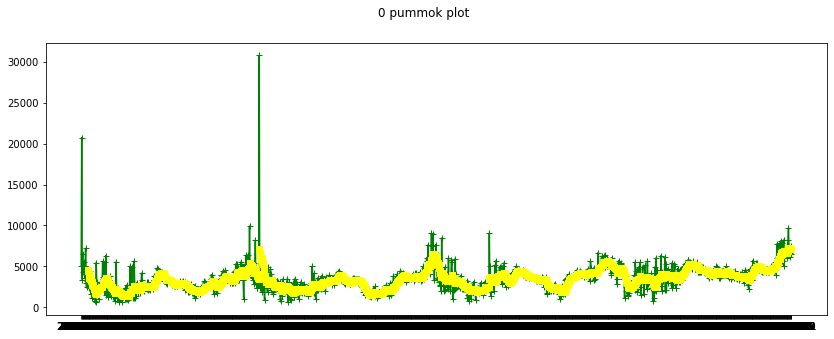

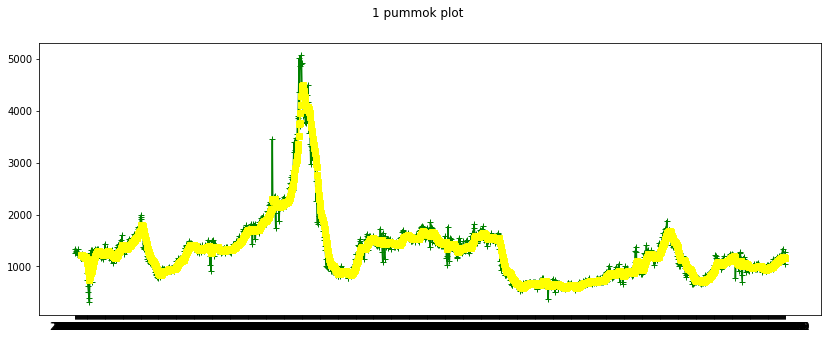

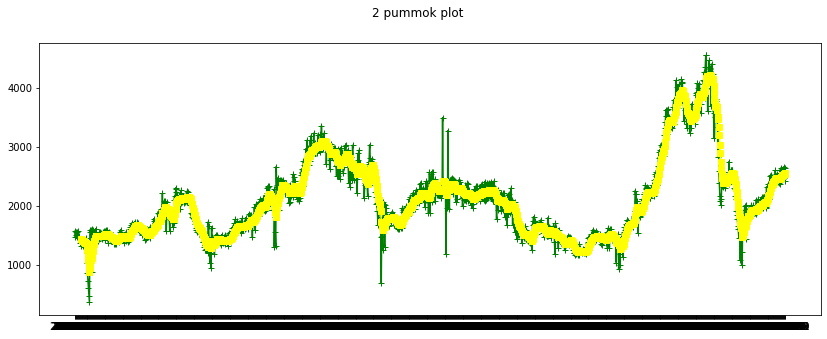

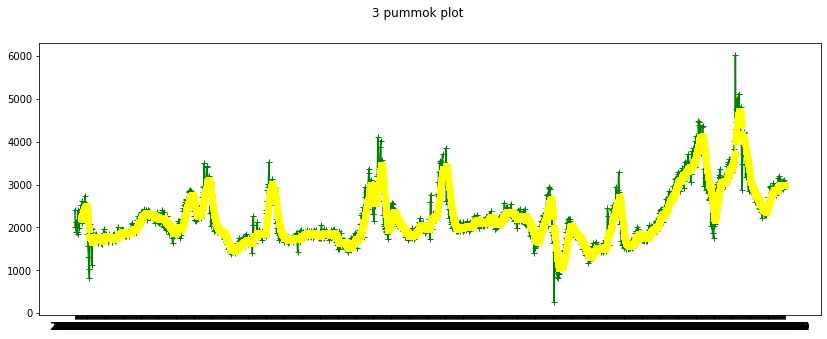

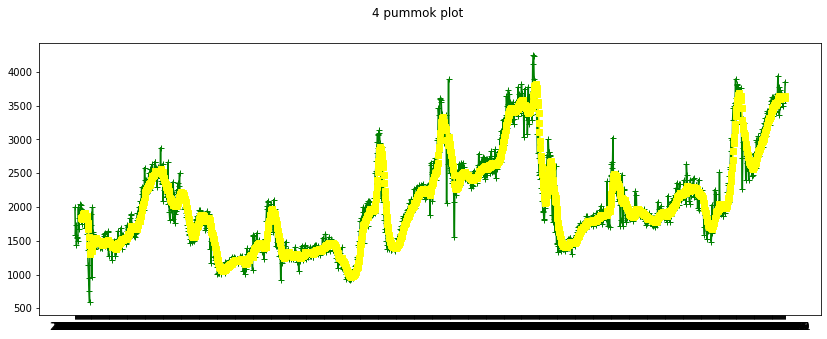

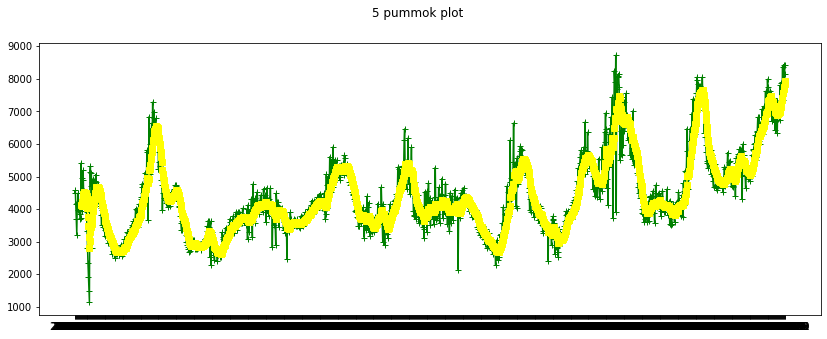

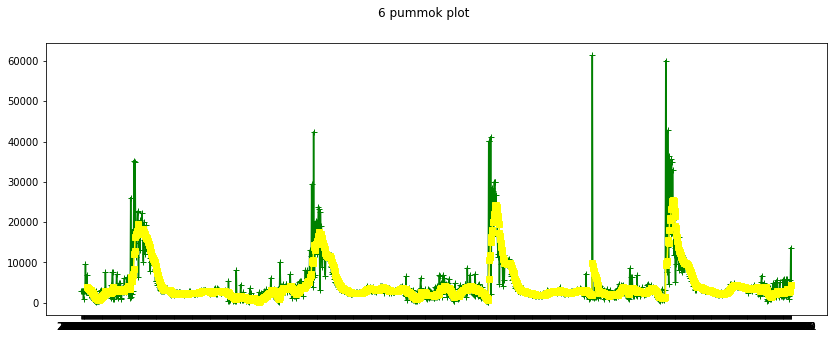

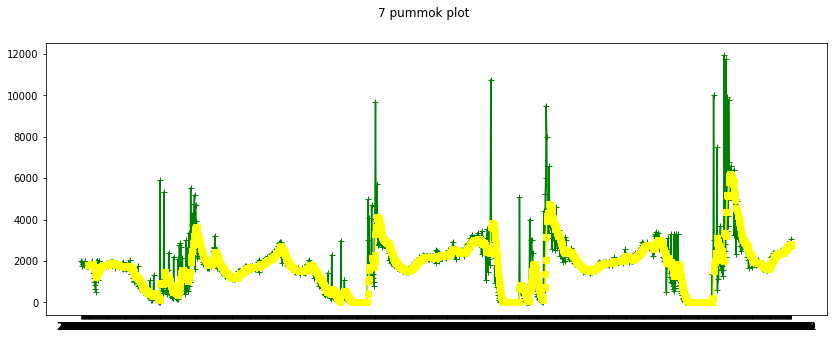

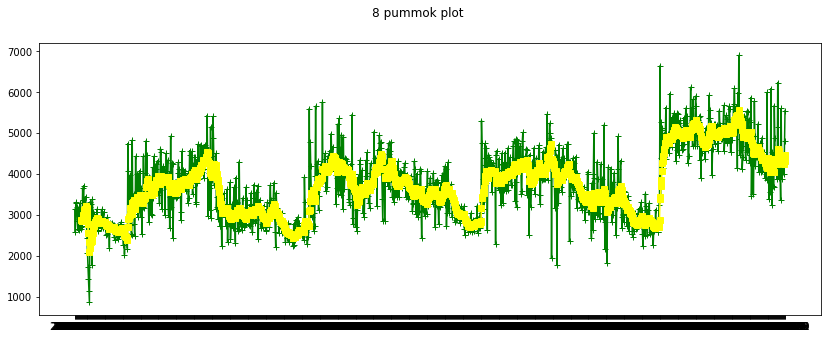

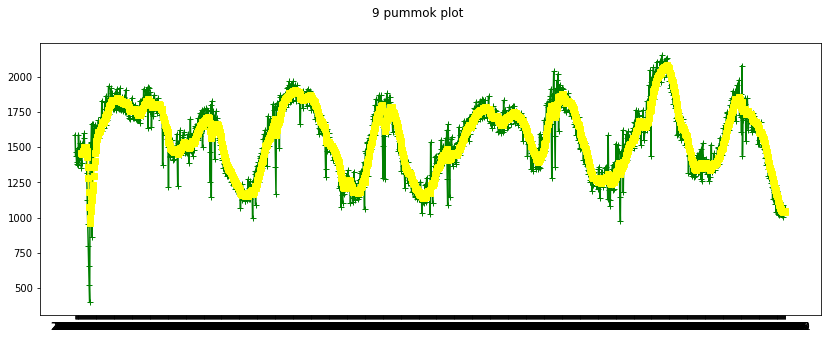

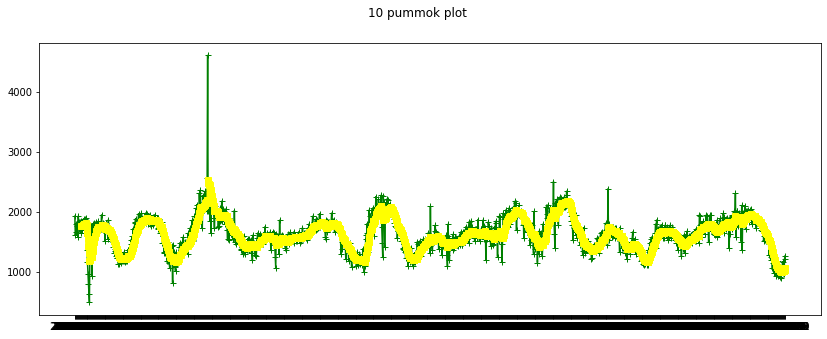

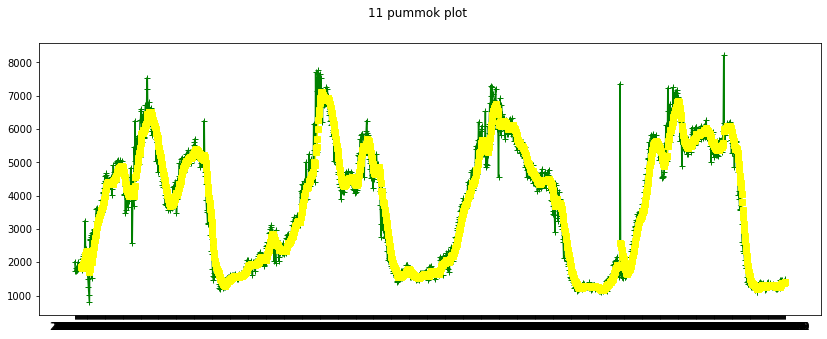

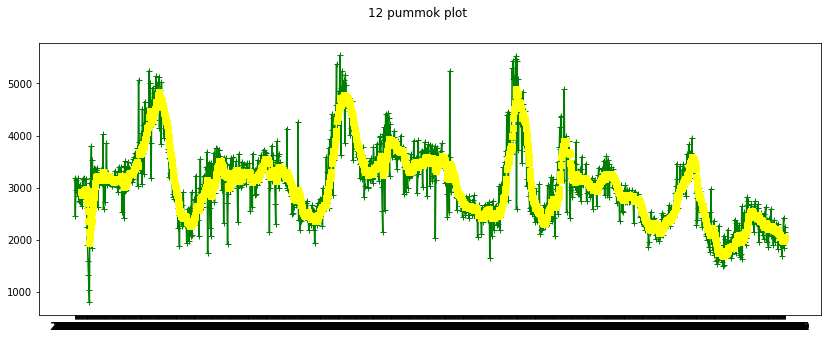

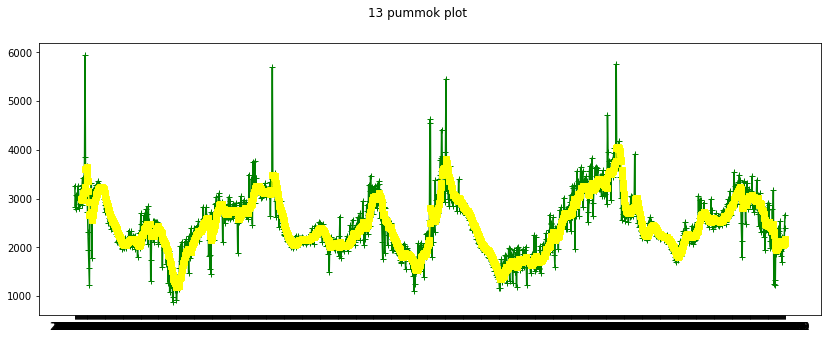

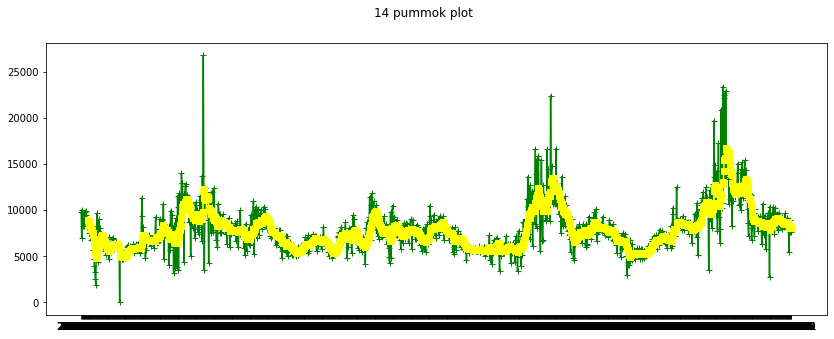

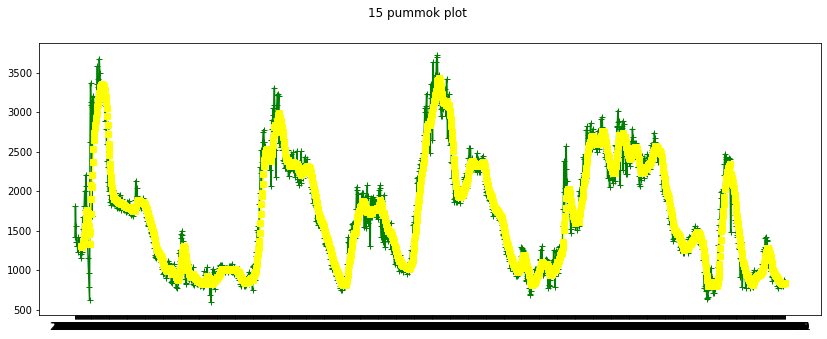

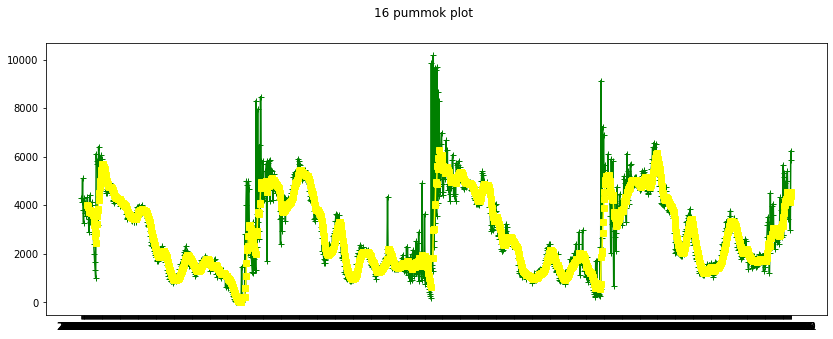

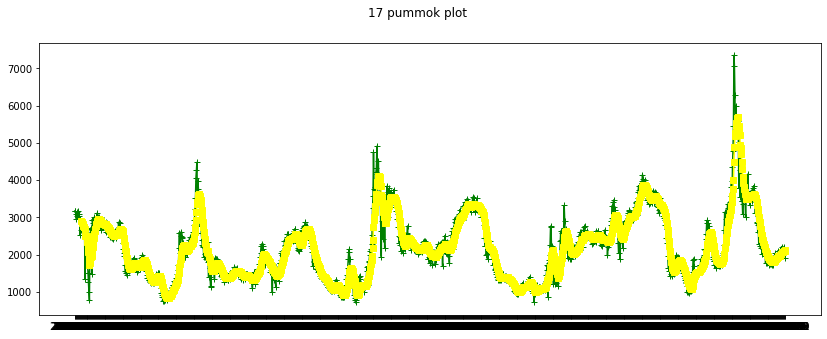

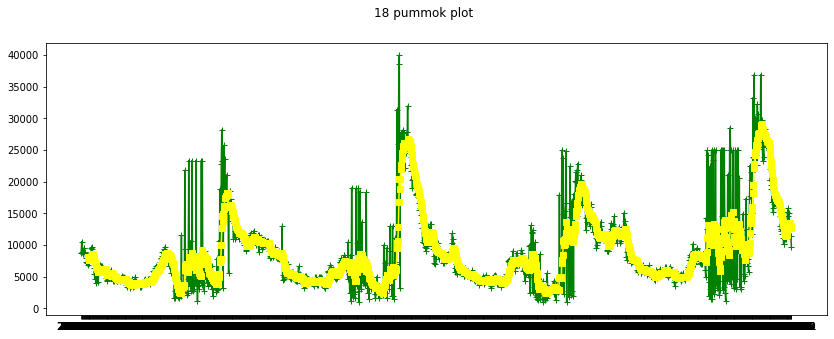

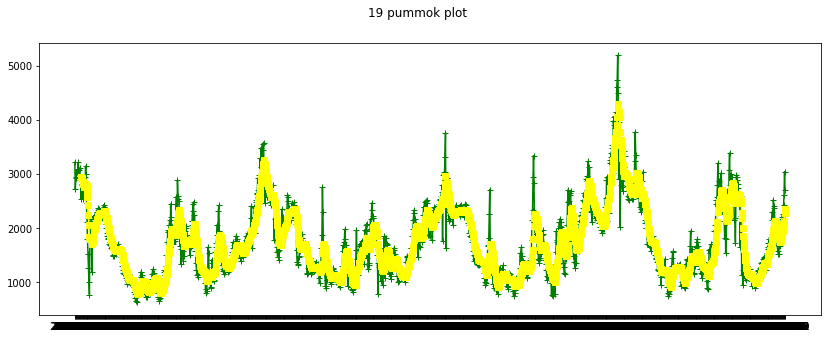

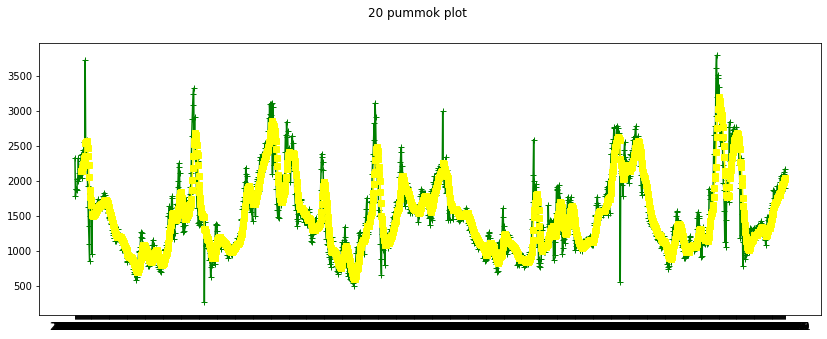

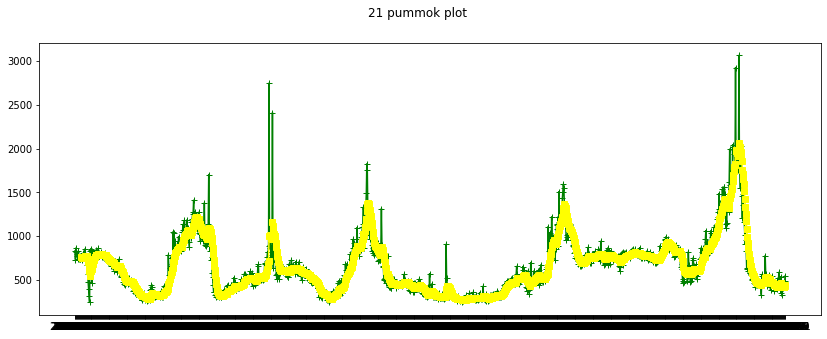

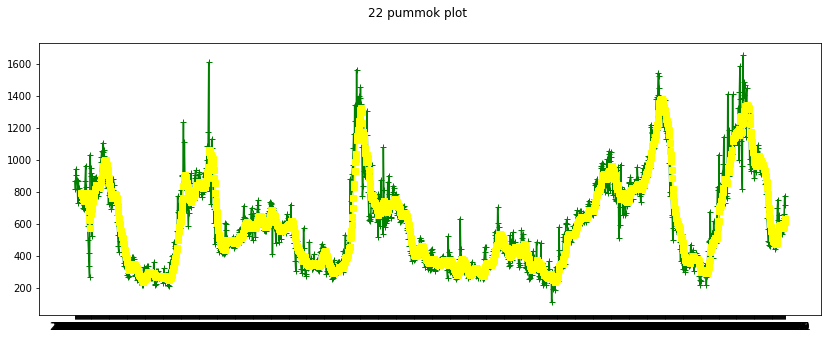

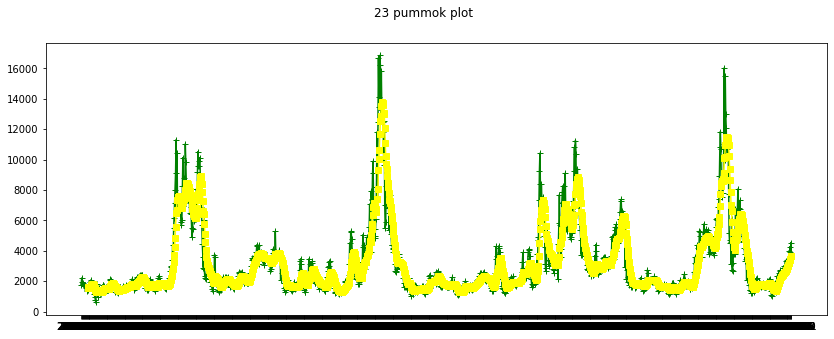

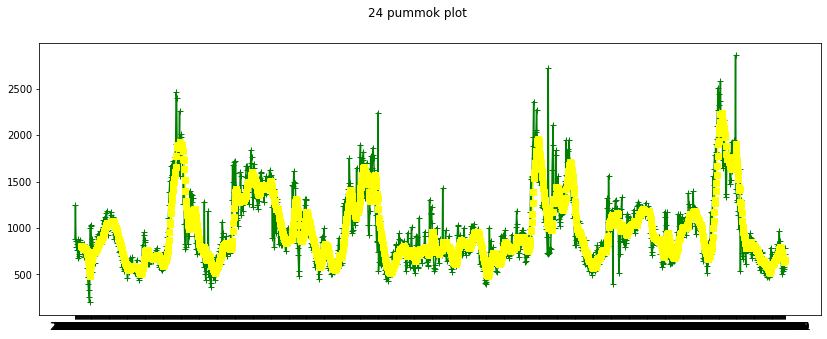

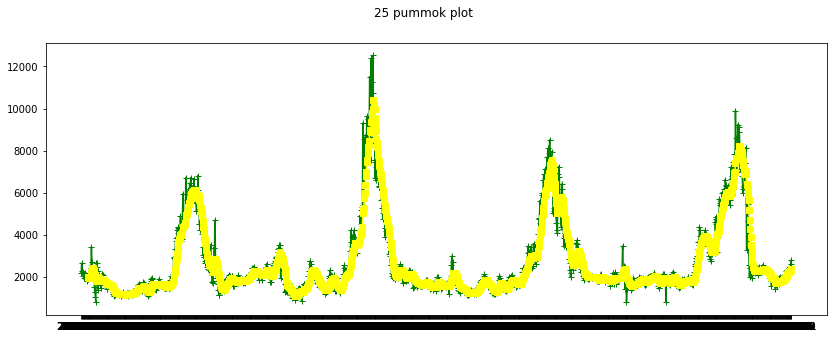

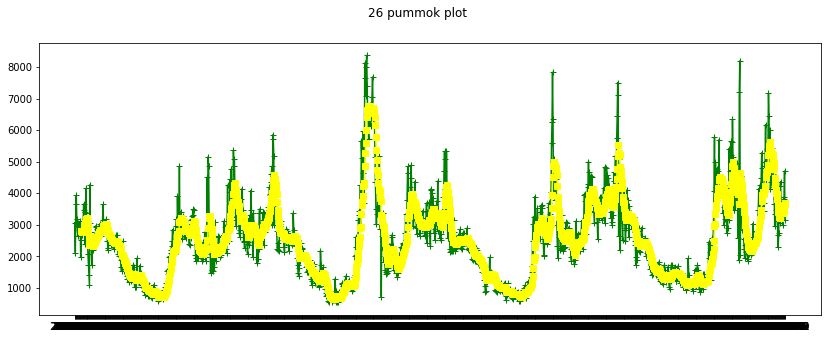

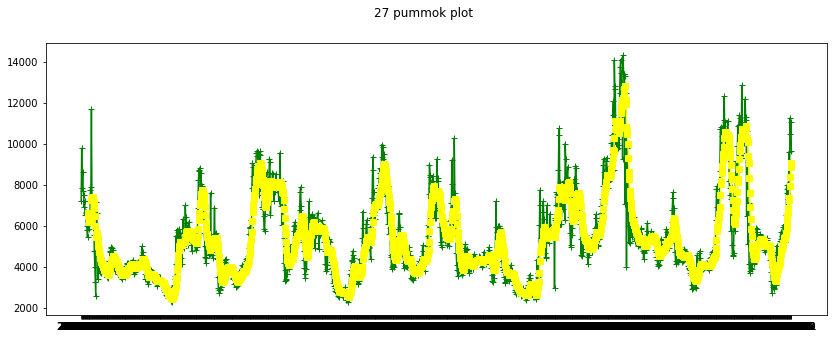

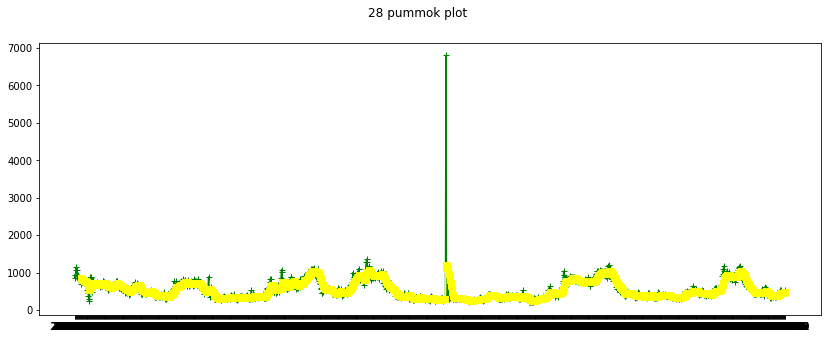

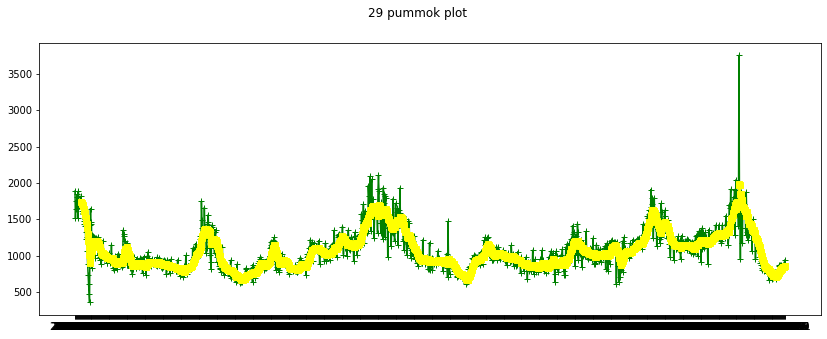

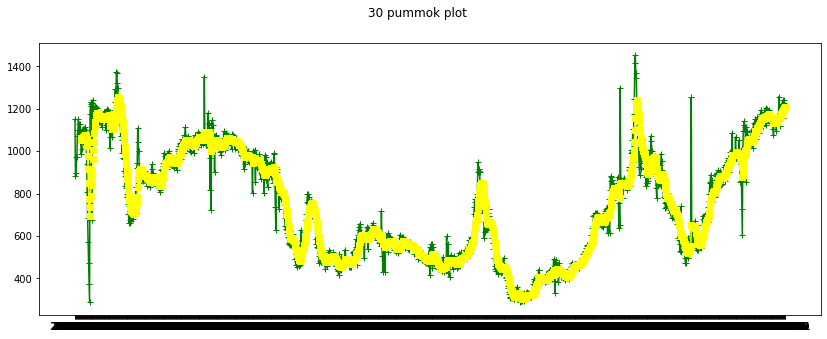

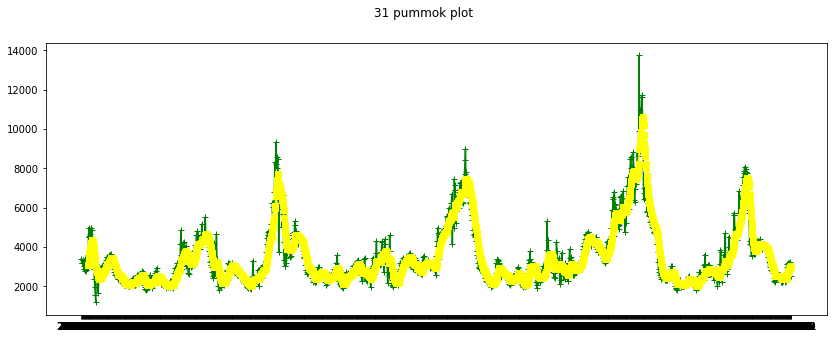

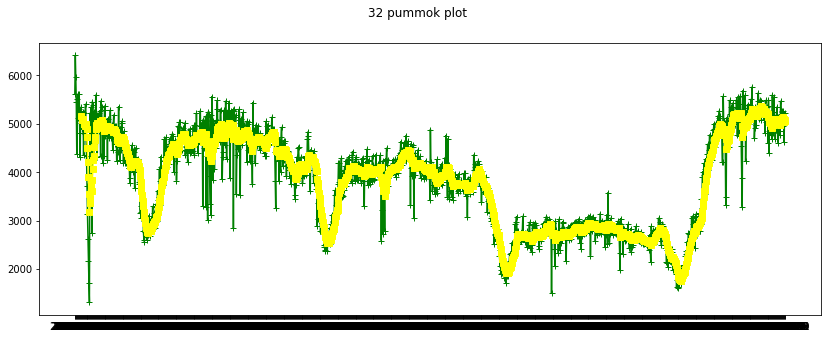

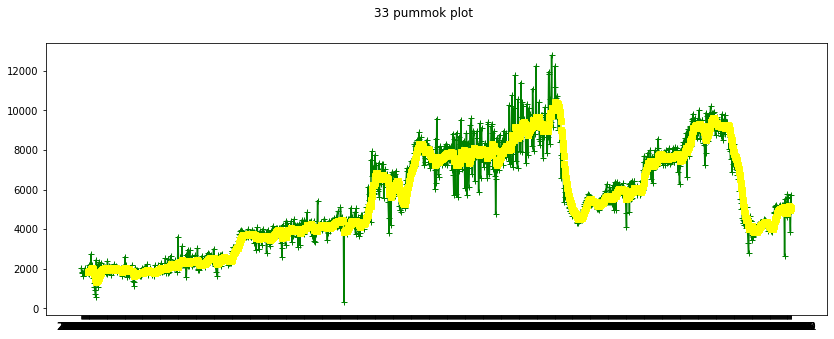

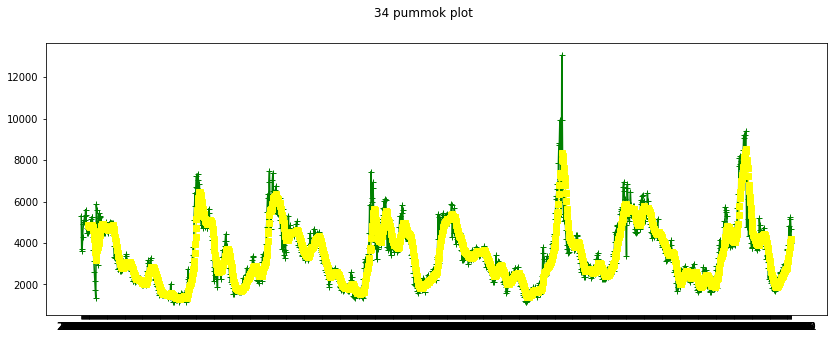

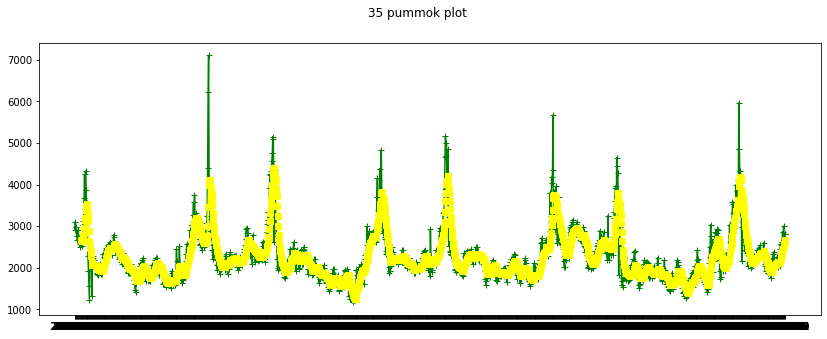

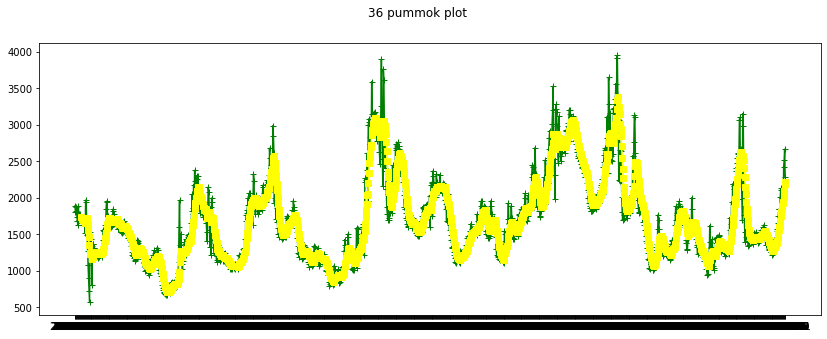

In [15]:
for i in range(37):
  df= globals()[f'train_total_{i}']
  #df['wma7'] = tb.WMA(df['해당일자_전체평균가격(원)'], 7)
  df['wma14'] = tb.WMA(df['해당일자_전체평균가격(원)'], 14)
  plt.figure(figsize=(14, 5))
  
  plt.plot(df['해당일자_전체평균가격(원)'], marker='+', color='g')
  #plt.plot(df['wma7'],  marker='*', color='yellow')
  plt.plot(df['wma14'],  marker='s', color='yellow')

  plt.suptitle(f'{i} pummok plot')
  plt.show()
  plt.close()

## 타겟값 스무싱
- 기존에 0인건 채웠지만 
- 위로 나타나는 아웃라이어도 처리해주기 위해 그나마 비슷한 wma14로 적용하고 bfill하자

In [16]:
def make_smoothing(df):
  df['해당일자_전체평균가격(원)'] = tb.WMA(df['해당일자_전체평균가격(원)'], 14)
  df.fillna(method='bfill', inplace=True)
  return df

In [17]:
# train_data smoothing 해주기~
for i in range(37):
  globals()[f'train_smoothing_{i}'] = make_smoothing(globals()[f'train_total_{i}'])

In [18]:
# nan이 생겼나 확인
for i in range(37):
  print(len(globals()[f'train_smoothing_{i}']), globals()[f'train_smoothing_{i}'].isna().sum().sum())

1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0
1461 0


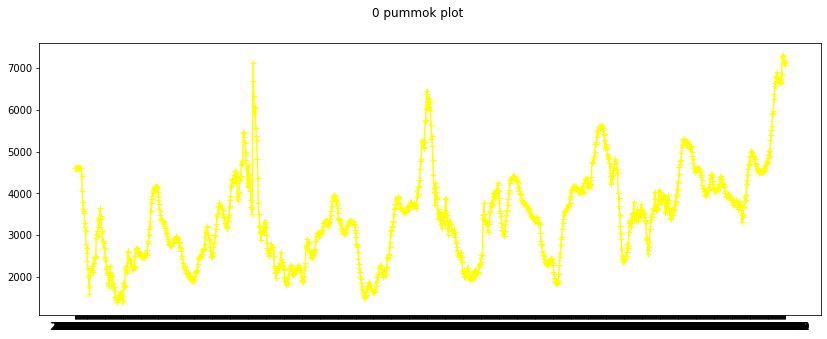

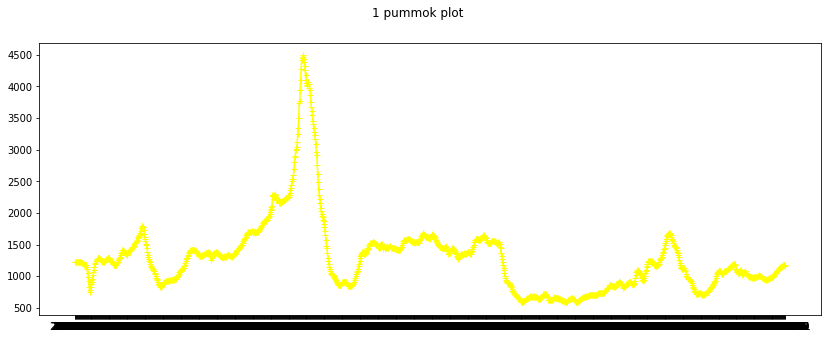

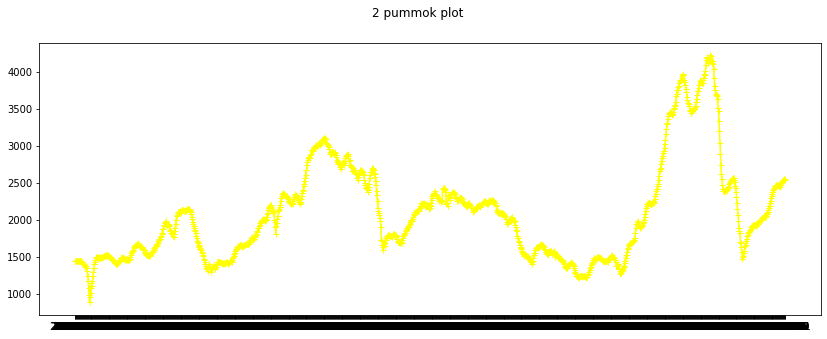

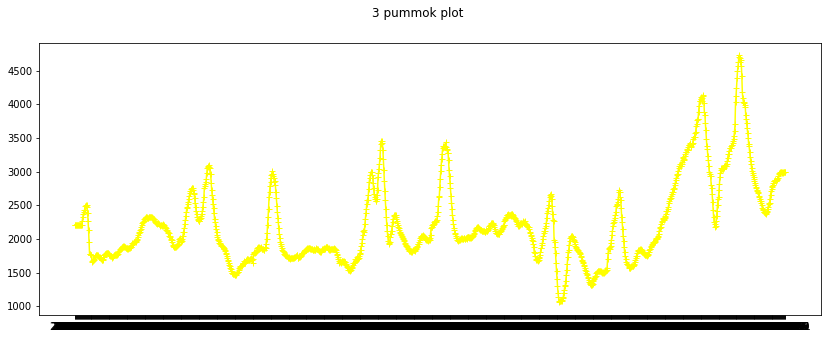

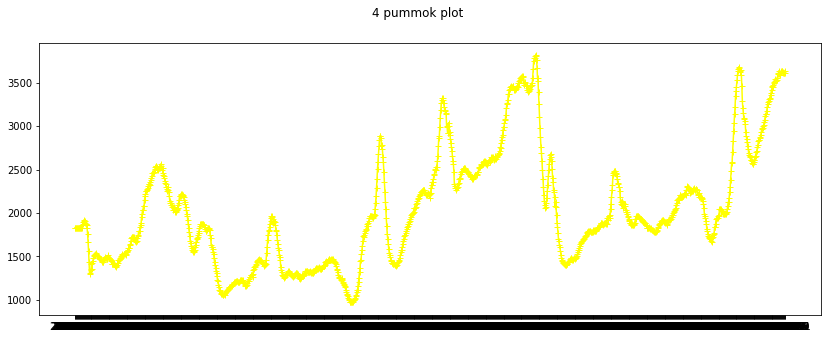

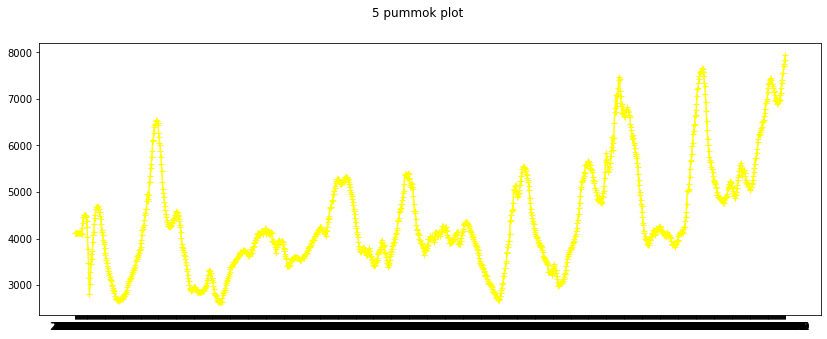

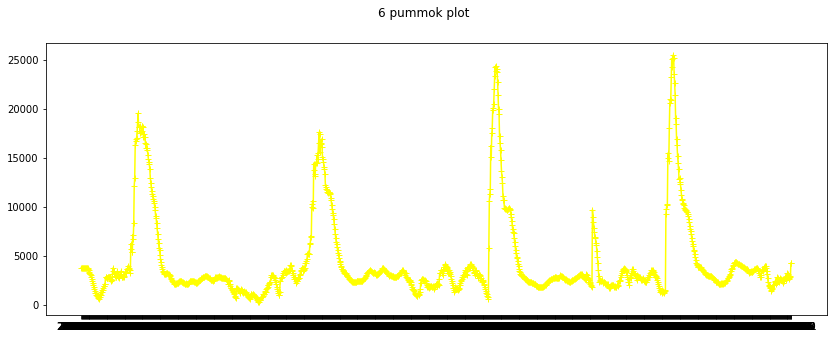

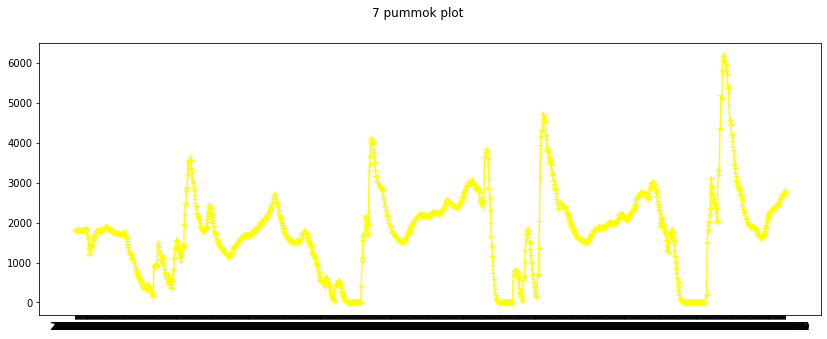

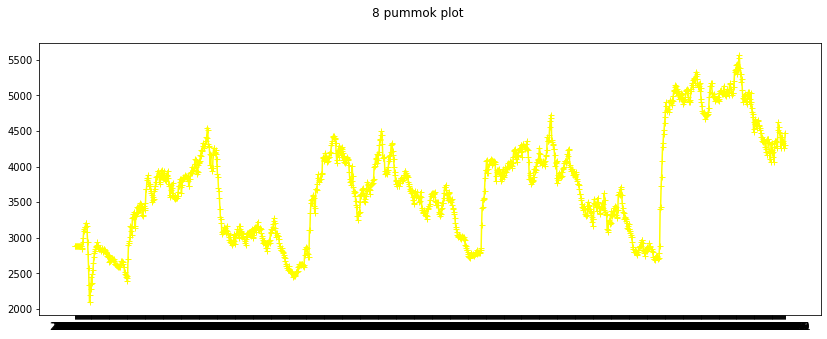

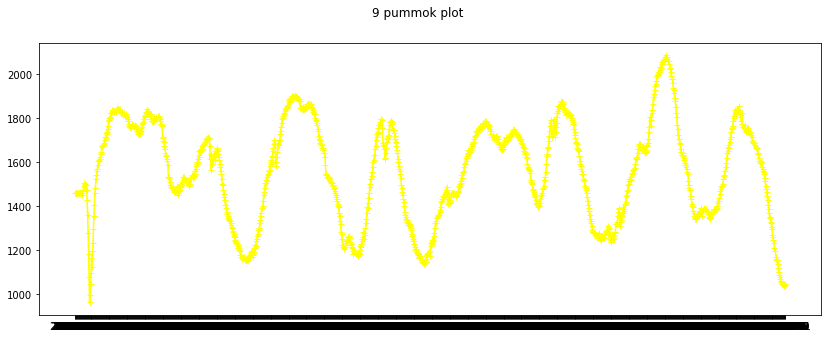

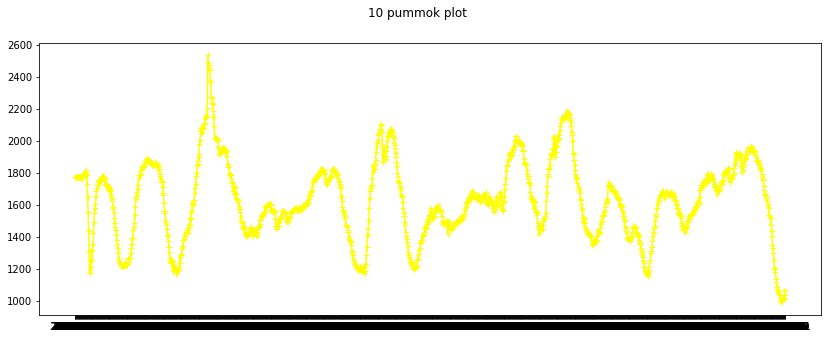

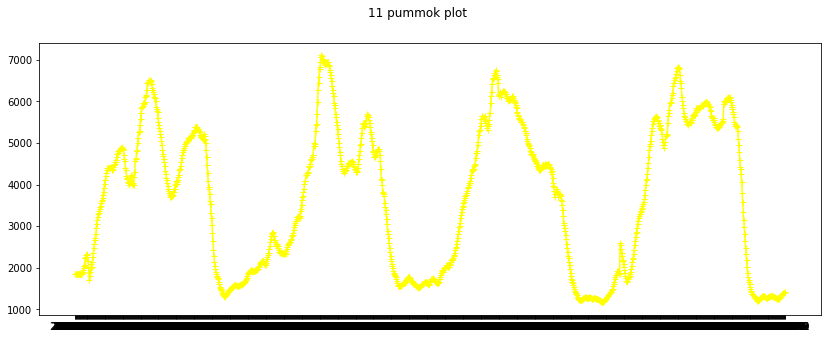

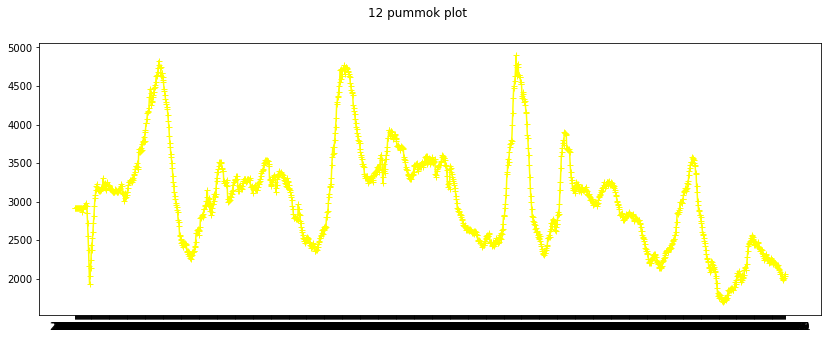

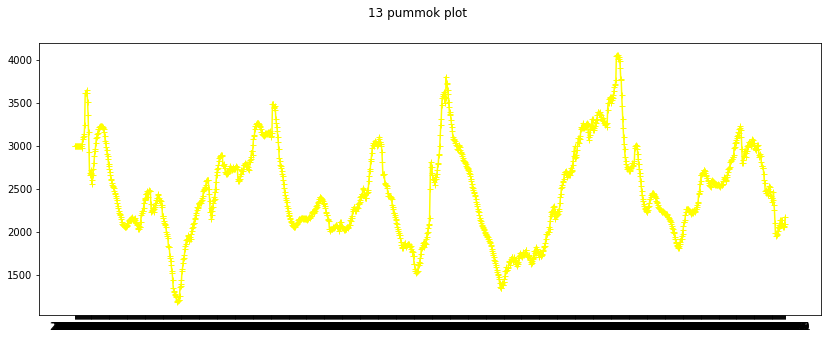

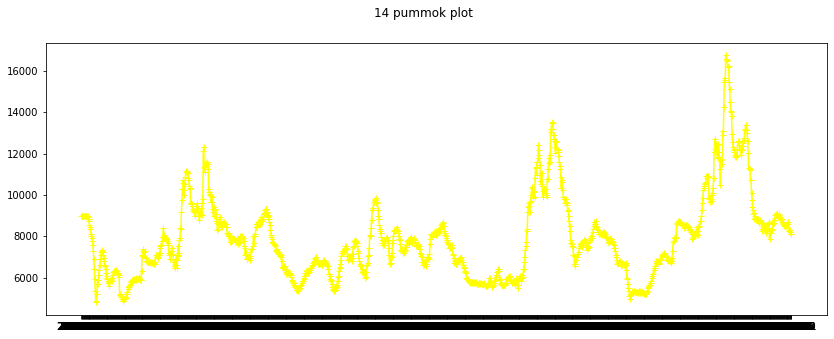

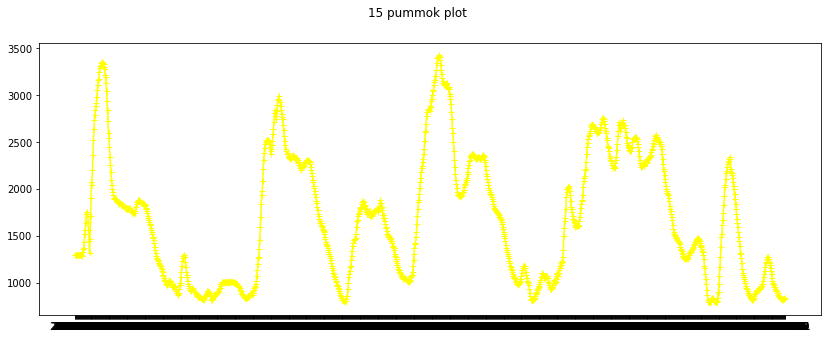

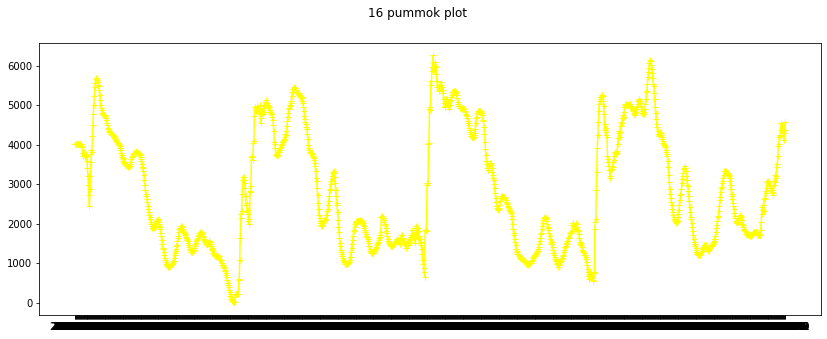

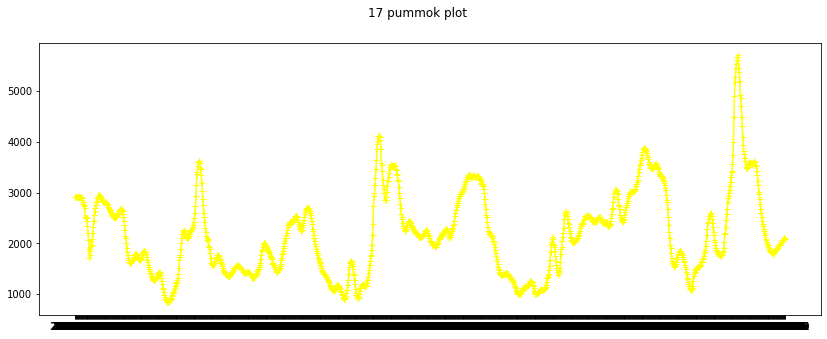

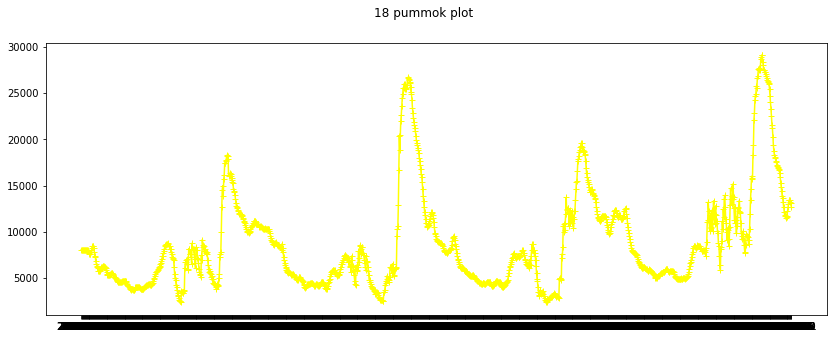

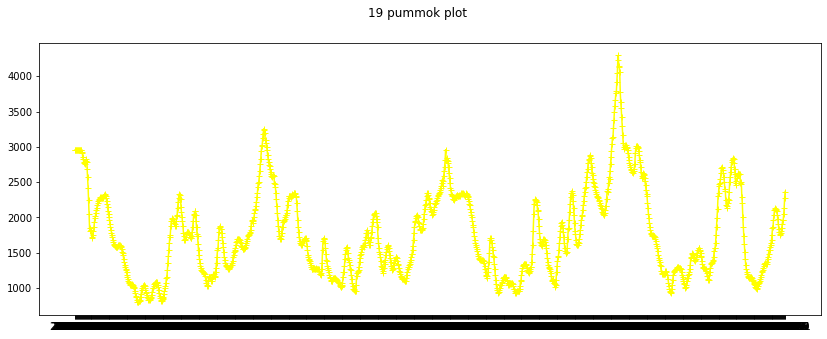

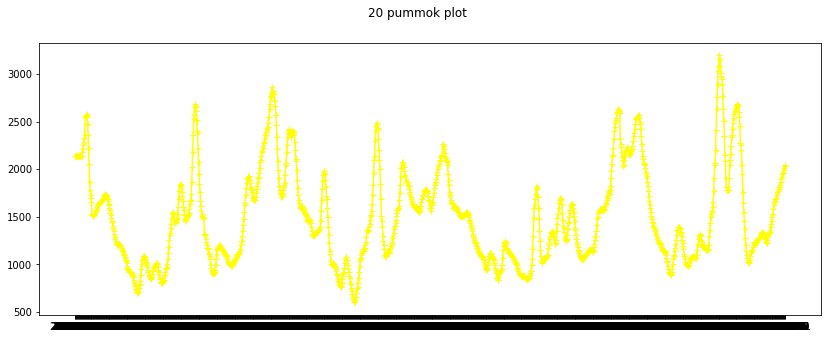

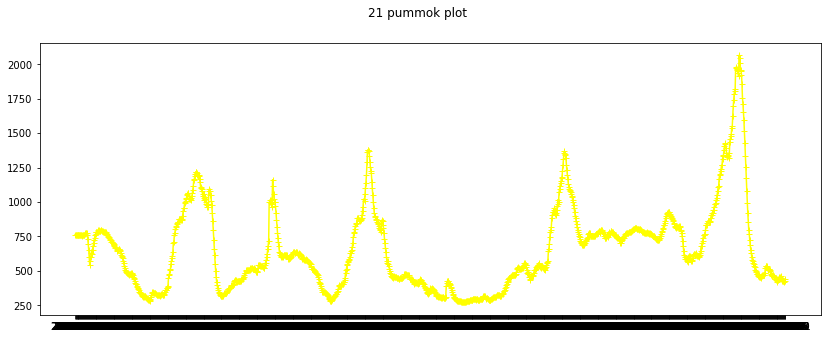

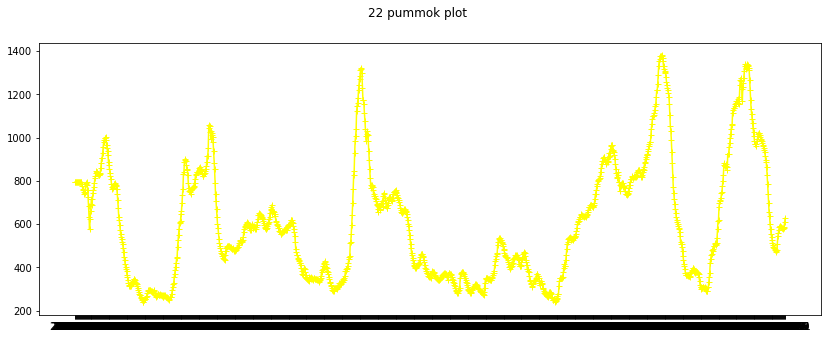

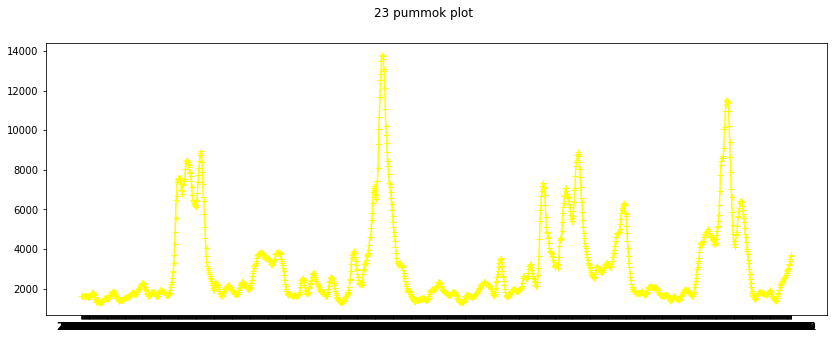

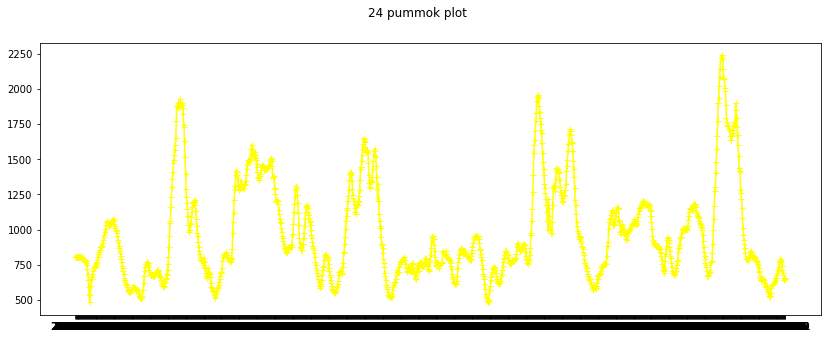

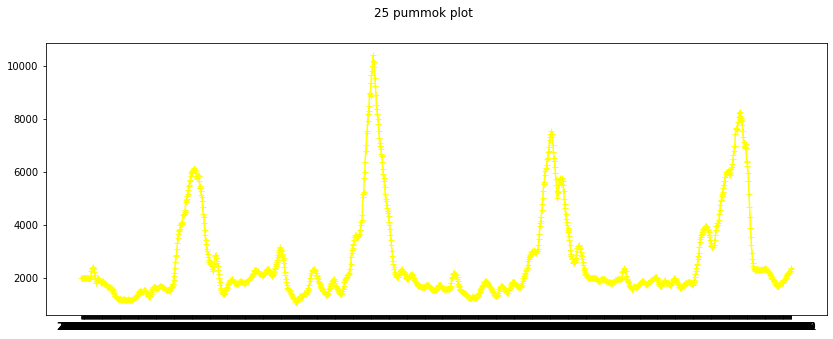

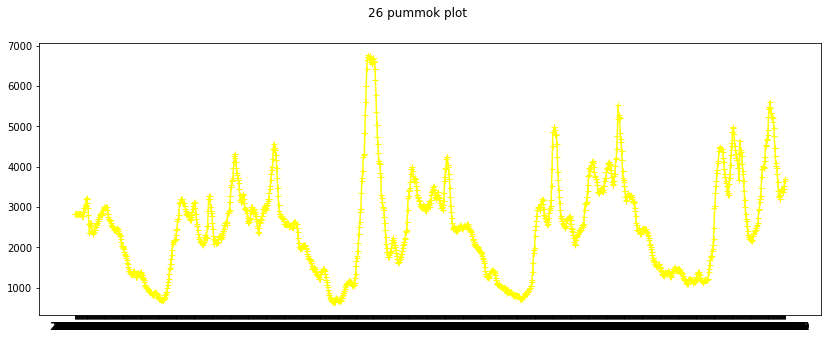

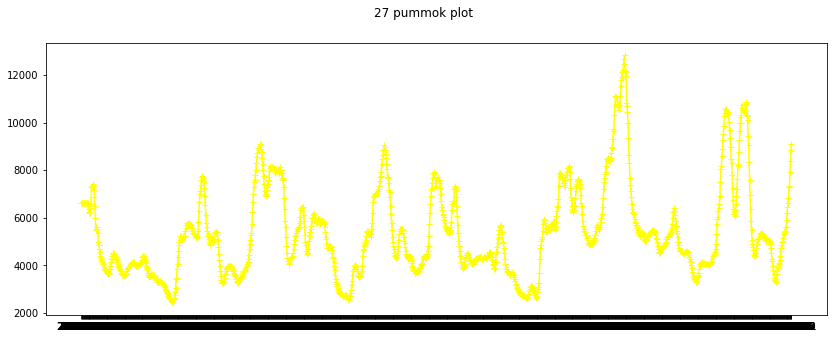

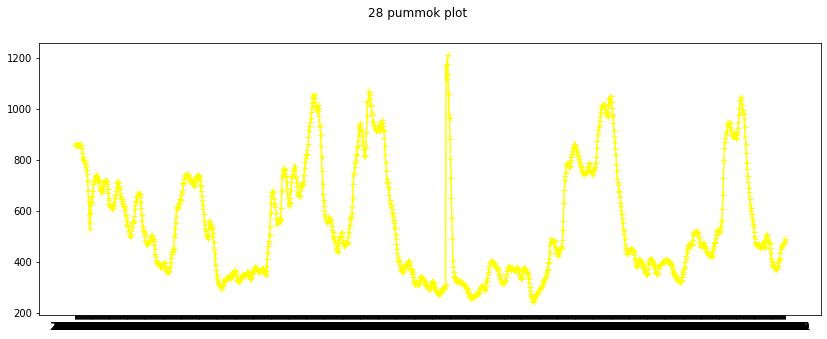

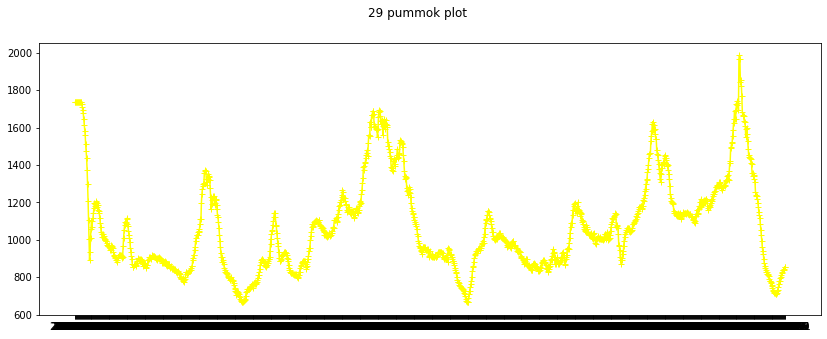

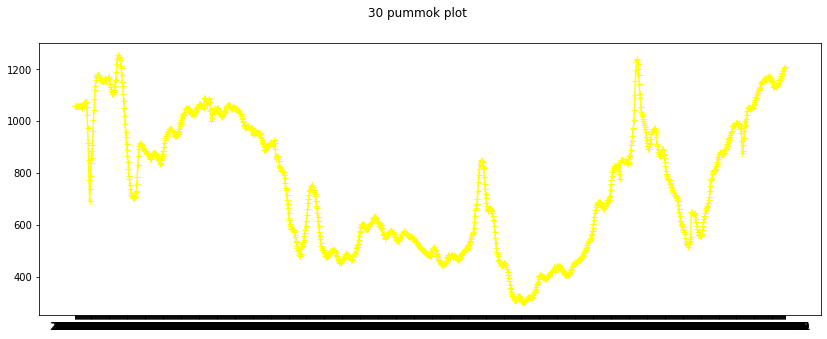

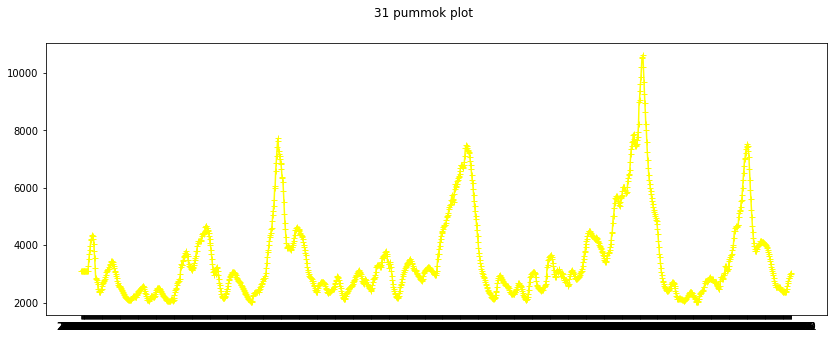

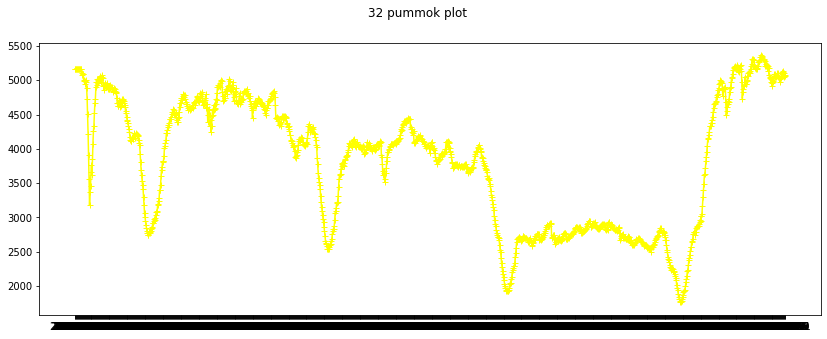

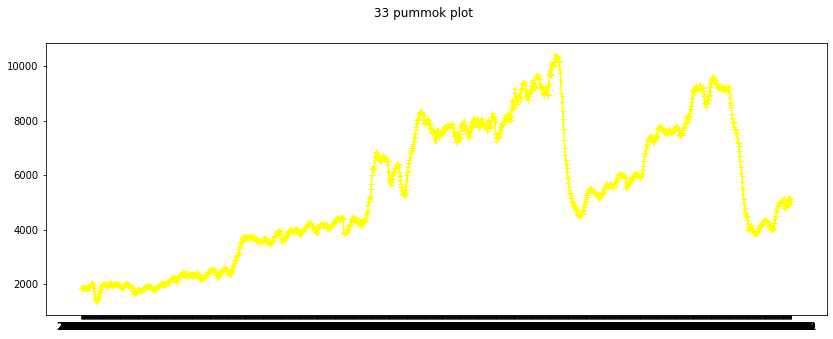

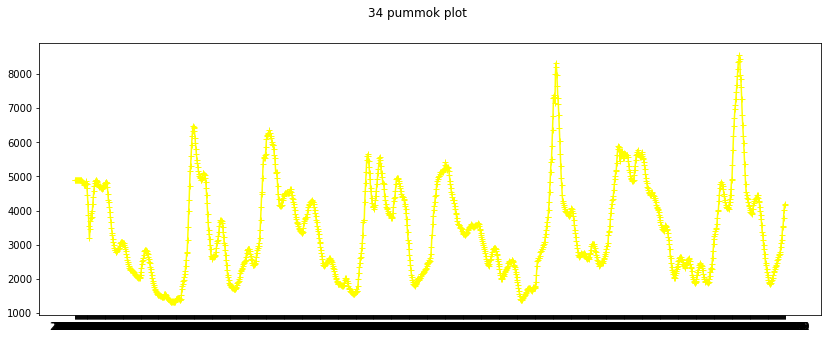

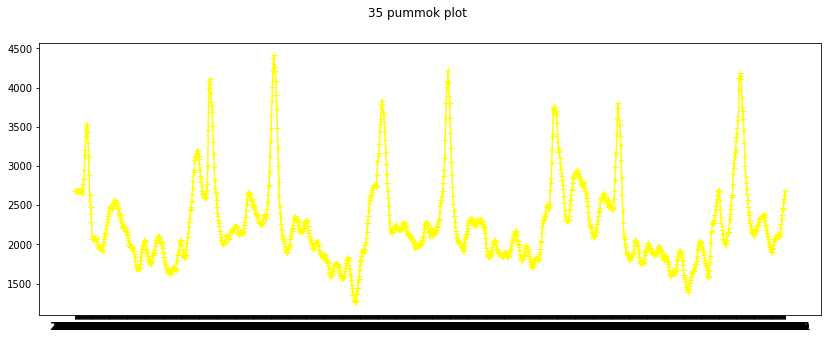

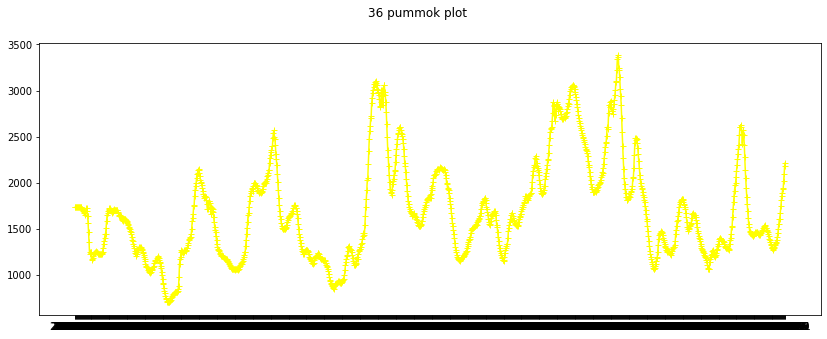

In [19]:
# 변경된거 한번 확인
for i in range(37):
  df= globals()[f'train_smoothing_{i}']
  plt.figure(figsize=(14,5))
  plt.plot(df['해당일자_전체평균가격(원)'], marker='+', color='yellow')
  #plt.plot(df['wma7'],  marker='*', color='yellow')
  # plt.plot(df['wma14'],  marker='s', color='yellow')

  plt.suptitle(f'{i} pummok plot')
  plt.show()
  plt.close()

In [20]:
# OLS Feature selection을 위한 함수
def OLS_report(df, seed):
    
    
    
    if len(df.columns)<len(train_smoothing_0.columns): # 주산지2의 날씨 데이터가 없다. 예외처리
      model = sm.OLS.from_formula("해당일자_전체평균가격 ~단가+거래량+초기온도_0+최대온도_0+최저온도_0+ 평균온도_0+강수량_0+ 습도_0+초기온도_1+최대온도_1+최저온도_1+ 평균온도_1+강수량_1+ 습도_1+일자별_domae가격_최대+일자별_domae가격_평균+ 일자별_domae가격_최소+ 일자별_somae가격_최대+일자별_somae가격_평균+ 일자별_somae가격_최소+ 수출중량+ 수출금액+ 수입중량+ 수입금액+무역수지"
                                ,data=df)
    else:
      model = sm.OLS.from_formula("해당일자_전체평균가격 ~단가+거래량+초기온도_0+최대온도_0+최저온도_0+ 평균온도_0+강수량_0+ 습도_0+초기온도_1+최대온도_1+최저온도_1+ 평균온도_1+강수량_1+ 습도_1+초기온도_2+최대온도_2+최저온도_2+ 평균온도_2+강수량_2+ 습도_2 +일자별_domae가격_최대+일자별_domae가격_평균+ 일자별_domae가격_최소+ 일자별_somae가격_최대+일자별_somae가격_평균+ 일자별_somae가격_최소+ 수출중량+ 수출금액+ 수입중량+ 수입금액+무역수지"
                                ,data=df)
    return model.fit()




def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    # conf_lower = results.conf_int()[0]
    # conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff
                              #  "conf_lower":conf_lower,
                              #  "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals"]]
    return results_df





def OLS_feature_selection(df):
  df.columns = df.columns.str.replace(r'\([^)]*\)','',regex= True) # 컬럼에서 문자 기호 같은거 있으면 OLS 안돌아간다.     
                                                                  # 테스트 데이터에도 적용해야한다. 컬럼명 바꿔야하니깐.
  result = OLS_report(df,42)
  ols_report_df = results_summary_to_dataframe(result).reset_index()
  ols_report_df = ols_report_df[ols_report_df['index'] !='Intercept']
  selected_col = list(ols_report_df[ols_report_df['pvals']<0.05]['index'].values) 
  selected_df = df[selected_col]
  selected_df['해당일자_전체평균가격'] = df['해당일자_전체평균가격']
  return selected_df        

In [21]:
# 유의수준을 토대로 columns selection
for i in range(37):
  globals()[f'total_{i}'] = OLS_feature_selection(globals()[f'train_smoothing_{i}'])

In [22]:
# 품목별로 컬럼 확인
for i in range(37):
  print(f"{i} 품목의 selected_columns : {list(globals()[f'total_{i}'].columns)}")

0 품목의 selected_columns : ['단가', '습도_0', '최저온도_1', '평균온도_1', '최대온도_2', '습도_2', '일자별_domae가격_최대', '일자별_domae가격_평균', '일자별_domae가격_최소', '일자별_somae가격_최대', '일자별_somae가격_최소', '해당일자_전체평균가격']
1 품목의 selected_columns : ['단가', '거래량', '습도_0', '최대온도_1', '평균온도_1', '습도_1', '최대온도_2', '최저온도_2', '평균온도_2', '습도_2', '일자별_domae가격_최대', '일자별_domae가격_평균', '일자별_domae가격_최소', '일자별_somae가격_최대', '일자별_somae가격_평균', '일자별_somae가격_최소', '수출중량', '수출금액', '해당일자_전체평균가격']
2 품목의 selected_columns : ['단가', '거래량', '습도_0', '최저온도_1', '최저온도_2', '습도_2', '일자별_somae가격_평균', '일자별_somae가격_최소', '수출중량', '수출금액', '수입금액', '무역수지', '해당일자_전체평균가격']
3 품목의 selected_columns : ['단가', '거래량', '최저온도_1', '평균온도_1', '습도_1', '일자별_domae가격_평균', '일자별_somae가격_평균', '일자별_somae가격_최소', '수출중량', '수출금액', '수입중량', '수입금액', '무역수지', '해당일자_전체평균가격']
4 품목의 selected_columns : ['단가', '거래량', '최저온도_0', '평균온도_1', '최저온도_2', '습도_2', '일자별_domae가격_평균', '일자별_domae가격_최소', '일자별_somae가격_최대', '일자별_somae가격_최소', '수출중량', '해당일자_전체평균가격']
5 품목의 selected_columns : ['단가', '거래량', '최대온도_0', '평균온도_0', 

In [23]:
for i in range(37):
  print(globals()[f'total_{i}']['해당일자_전체평균가격'].isna().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [24]:
def scaling_df(df):
  scaler = StandardScaler()
  
  
  tmp = df.drop('해당일자_전체평균가격',axis=1).copy()
  scaler.fit(tmp)
  df_scaled = scaler.transform(tmp)
  df_scaled = pd.DataFrame(data=df_scaled, columns = tmp.columns)
  df_scaled['log_target'] = np.log1p(df['해당일자_전체평균가격']).values 
  return df_scaled

for i in range(37):
  globals()[f'train_scaled_{i}'] = scaling_df(globals()[f'total_{i}'])

In [28]:
for i in range(37):
  print(globals()[f'train_scaled_{i}'].isna().sum().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [29]:
try_cnt = 14 # 모델이나 체크포인트를 각자 다른 폴더에 저장해주기 위해
            # 새로운거 시도할때마다 숫자 바꿔서 내면된다.


In [30]:
def make_Tensor(array):
    return tf.convert_to_tensor(array, dtype=tf.float32)

def astype_data(data):
    df = data.astype(np.float32)
    return make_Tensor(df)

In [31]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):

    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [32]:
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(28)(x) # 4주 예측
    return keras.Model(inputs, outputs)

In [33]:
def call_back_set(name, epoch, batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=100)

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}') == False:
        os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}')

    filename = f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}/{name}-{epoch}-{batch_size}.h5'

    checkpoint = ModelCheckpoint(filename,
                                 monitor='val_loss',
                                 verbose=1,
                                 save_best_only=True,
                                 save_weights_only=True,
                                 mode='auto'
                                 )
    return [early_stopping, checkpoint]

In [34]:
def train(x_train, y_train, x_val, y_val, name, epoch, batch_size, learning_rate = 0.001, verbose = 1):


    model = build_model(
    x_train.shape[1:],
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    )

    model.compile(
        loss="mean_squared_error",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    )


    # Train the model
    with tf.device('/device:GPU:0'):
        history1 = model.fit(
            x_train, y_train,
            epochs = epoch,
            steps_per_epoch=len(x_train) / batch_size,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
            validation_steps=len(x_val) / batch_size,
            shuffle=False,
            callbacks=call_back_set(name, epoch, batch_size),
            verbose=verbose)

    return model

In [35]:
def time_window(df, t, t_sep):
    seq_len = t
    seqence_length = seq_len + t_sep

    result = []
    for index in tqdm(range(len(df) - seqence_length)):
        result.append(df[index: index + seqence_length].values)

    return np.array(result)

In [36]:
epoch = 1000
batch = 15

In [37]:
for i in range(37):


    df_number = i
    df = globals()[f'train_scaled_{i}']
    
    # nan 처리
    df.fillna(0, inplace = True)
    
  

    

    # 변수와 타겟 분리
    x, y = df[[i for i in df.columns if i != 'log_target']], df['log_target']

    # 2주 입력을 통한 이후 4주 예측을 위해 y의 첫 14일을 제외
    y = y[14:]

    # time series window 생성
    data_x = time_window(x, 13, 1)
    data_y = time_window(y, 27, 1)

    # y의 길이와 같은 길이로 설정
    xdata = data_x[:len(data_y)]
    ydata = data_y

    # train, validation 분리 (8 : 2)
    x_train, x_val, y_train, y_val = train_test_split(xdata, ydata, test_size=0.2, shuffle=False, random_state=119)

    # transformer 모델 훈련
    transformer = train(astype_data(x_train), y_train, astype_data(x_val), y_val, f'transformer-{df_number}', epoch, batch)
    transformer.load_weights(f'/content/drive/MyDrive/농산물예측/aT_data/check{try_cnt}/transformer-{df_number}-{epoch}-{batch}.h5')

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}') == False:
         os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}')

    
    
    
    # 모델 저장
    transformer.save(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}/transformer-{df_number}-{epoch}-{batch}.h5')

Output hidden; open in https://colab.research.google.com to view.

In [38]:
for i in tqdm(range(10)):
  
  make_csv(f'/content/drive/MyDrive/농산물예측/aT_data/aT_test_raw/sep_{i}/','test') 
  
  for j in range(37):
    # print(f'sep:{i}, 품목:{j}')
    # print(len(globals()[f'test_total_sep_{i}_{j}'])) # df row수 - 0이 있나 확인하기 위해서

    

    # 정규 표현식 적용
    globals()[f'test_total_sep_{i}_{j}'].columns = globals()[f'test_total_sep_{i}_{j}'].columns.str.replace(r'\([^)]*\)','',regex= True)

    # 스케일링 & 타겟값 변환
    #globals()[f'train_scaled_{i}'] = scaling_df(globals()[f'total_{i}'])
    globals()[f'test_total_sep_{i}_{j}'] = scaling_df(globals()[f'test_total_sep_{i}_{j}'])

    # train 데이터랑 똑같이 selection
    globals()[f'test_total_sep_{i}_{j}'] = globals()[f'test_total_sep_{i}_{j}'][list(globals()[f'train_scaled_{j}'].columns)]

    

    # 해당일자평균가격 테스트 데이터에서는 타겟값 없애고 돌리네
    globals()[f'test_total_sep_{i}_{j}'].drop('log_target',axis=1, inplace=True)


    file_number = j

    # nan 처리
    globals()[f'test_total_sep_{i}_{j}'].fillna(0, inplace = True)
    # 형상 맞추기 코드는 아직 넣지 않았다. (안넣어도 되지 않을까?)

    # x_test 생성
    df_test = astype_data(globals()[f'test_total_sep_{i}_{j}'].values.reshape(1, globals()[f'test_total_sep_{i}_{j}'].values.shape[0], globals()[f'test_total_sep_{i}_{j}'].values.shape[1]))



    # model test
    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}') == False:
            os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}')

    if os.path.exists(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}') == False:
            os.mkdir(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}')

    # 해당하는 모델 불러오기
    model_test = tf.keras.models.load_model(f'/content/drive/MyDrive/농산물예측/aT_data/model{try_cnt}/transformer-{file_number}-{epoch}-{batch}.h5')
    pred = model_test.predict(df_test)


    # 여기서 다시 형변환 해주자!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!np.expm1
    pred = np.expm1(pred)

    

    # 결과 저장
    save_df = pd.DataFrame(pred).T
    save_df.to_csv(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{i}/predict_{file_number}.csv', index=False)


100%|██████████| 37/37 [00:13<00:00,  2.84it/s]

100%|██████████| 37/37 [00:12<00:00,  3.08it/s]

100%|██████████| 37/37 [00:02<00:00, 12.36it/s]

100%|██████████| 37/37 [00:01<00:00, 18.97it/s]

100%|██████████| 37/37 [00:11<00:00,  3.28it/s]

100%|██████████| 37/37 [00:10<00:00,  3.40it/s]

100%|██████████| 37/37 [00:03<00:00, 12.09it/s]

100%|██████████| 37/37 [00:01<00:00, 18.69it/s]

100%|██████████| 37/37 [00:11<00:00,  3.14it/s]

100%|██████████| 37/37 [00:11<00:00,  3.21it/s]

100%|██████████| 37/37 [00:02<00:00, 12.77it/s]

100%|██████████| 37/37 [00:01<00:00, 18.68it/s]

100%|██████████| 37/37 [00:10<00:00,  3.38it/s]

100%|██████████| 37/37 [00:11<00:00,  3.18it/s]

100%|██████████| 37/37 [00:03<00:00, 12.17it/s]

100%|██████████| 37/37 [00:01<00:00, 18.77it/s]

100%|██████████| 37/37 [00:10<00:00,  3.47it/s]

100%|██████████| 37/37 [00:12<00:00,  3.01it/s]

100%|██████████| 37/37 [00:03<00:00, 11.41it/s]

100%|██████████| 37/37 [00:01<00:00, 18.61it/s]

100%|██████████| 37/

In [39]:
# 이부분 세부적으로 다 바꿔야한다.



for k in tqdm(range(10)):

  globals()[f'set_df_{k}'] = pd.DataFrame()
  answer_df_list = glob(f'/content/drive/MyDrive/농산물예측/aT_data/model_output{try_cnt}/set_{k}/*.csv') # 예측한 결과 불러오기
  pum_list = glob(f'/content/drive/MyDrive/농산물예측/aT_data/aT_test_raw/sep_{k}/*.csv') # 기존 test input 불러오기
  pummok = [a for a in pum_list if 'pummok' in a.split('/')[-1]]

  for i in answer_df_list:
    df = pd.read_csv(i)
    number = i.split('_')[-1].split('.')[0]

    base_number = 0
    for p in pummok:
      if number == p.split('_')[-1].split('.')[0]:
        pum_df = pd.read_csv(p)

        if len(pum_df) != 0:
           base_number = pum_df.iloc[len(pum_df)-1]['해당일자_전체평균가격(원)']  # 기존 각 sep 마다 test input의 마지막 target 값 가져오기 (변동률 계산을 위해)
        else:
          base_number = np.nan

    globals()[f'set_df_{k}'][f'품목{number}']  = [base_number] + list(df[df.columns[-1]].values) # 각 품목당 순서를 t, t+1 ... t+28 로 변경

  globals()[f'set_df_{k}'] = globals()[f'set_df_{k}'][[f'품목{col}' for col in range(37)]] # 열 순서를 품목0 ~ 품목36 으로 변경

100%|██████████| 10/10 [00:03<00:00,  2.81it/s]


In [47]:
pd.options.display.max_columns=37
set_df_0

,품목0,품목1,품목2,품목3,품목4,품목5,품목6,품목7,품목8,품목9,품목10,품목11,품목12,품목13,품목14,품목15,품목16,품목17,품목18,품목19,품목20,품목21,품목22,품목23,품목24,품목25,품목26,품목27,품목28,품목29,품목30,품목31,품목32,품목33,품목34,품목35,품목36
0,3871.1250,1362.117613,2909.783785,3400.075583,3947.809169,9253.947514,2717.2800,3361.030923,4911.899864,1173.018633,1337.03482,2053.354945,3003.205509,3148.414256,6573.839289,1089.126835,3838.815254,2254.390206,12538.931552,2990.863631,2965.711352,505.929304,937.367871,4147.240906,1231.11322,3323.910031,3056.787271,8640.811309,602.005658,1105.412623,1566.274239,3633.464557,5454.710444,5619.188362,5230.620027,2905.100888,2087.675036
1,3957.9697,844.108300,2029.868000,2223.365000,2402.468000,4636.951000,2824.0288,636.053340,4706.423000,1673.853500,1779.09190,3131.185000,2979.889600,3462.064000,8315.393000,1569.574300,4133.125500,1843.687700,9499.544000,2084.707300,1735.025300,678.781500,458.100500,3183.745800,977.14390,2153.321300,1529.773700,5585.088400,484.793850,996.281560,636.844540,3635.275400,3019.604500,9295.853000,2740.946300,1787.613200,1475.366700
2,3957.3242,809.014800,2013.533300,2147.253700,2414.390100,4652.640000,2834.1743,597.265900,4704.878400,1687.719700,1775.92270,3126.445300,2983.698700,3472.436500,8304.660000,1574.448200,4145.120600,1852.466100,9555.047000,2161.767300,1867.565100,691.030460,460.716300,3275.931200,993.12085,2156.438200,1542.481600,5604.684600,482.118560,1003.202700,634.912800,3649.124500,3019.126200,9252.042000,2818.093000,1784.867300,1497.428200
3,3985.3499,771.024200,2038.466100,2209.920700,2436.628400,4667.767600,2825.6377,537.988500,4693.063500,1678.543200,1774.02920,3118.971000,2984.737800,3480.790800,8287.450000,1578.123000,4173.839000,1859.799300,9542.433000,2082.101000,1773.870100,679.779970,463.336600,3187.836700,1001.41960,2161.497300,1539.190800,5618.767600,482.299440,1009.032170,635.754500,3659.729200,3014.498300,9181.891000,2842.830000,1782.127300,1490.901100
4,3999.3342,835.779700,1995.735600,2162.509000,2420.564500,4683.538000,2792.1240,599.989100,4691.882000,1665.458600,1771.26110,3121.536900,2984.578400,3490.357000,8276.131000,1585.546100,4215.516600,1879.977700,9619.724000,2095.688000,1801.827100,689.871800,466.451230,3377.731400,1016.91174,2167.743700,1507.899200,5638.186000,482.846370,1014.202600,637.897460,3684.600300,3012.103800,9092.303000,2902.269500,1781.869800,1503.807900
5,3988.2974,778.242550,2032.247800,2216.319600,2391.477300,4699.281200,2782.8380,616.437100,4688.642600,1669.567100,1766.49280,3118.994600,2984.800500,3498.794400,8263.598000,1596.991800,4214.756300,1893.608000,9628.370000,2166.308800,1930.804400,702.704350,469.830930,3333.273200,1030.03670,2171.543500,1505.911100,5655.071300,482.611570,1021.349000,640.348800,3703.226800,3012.037600,9019.774000,2894.249500,1782.555900,1494.521500
6,3985.1940,841.951500,2012.064200,2096.140900,2417.684000,4718.150000,2763.4258,557.007450,4676.743000,1669.507400,1763.75590,3115.497600,2978.965800,3509.672000,8250.139000,1606.002400,4174.826700,1910.821800,9667.801000,2116.464600,2041.293200,681.652340,473.000400,3285.734000,1044.40530,2174.021700,1540.949200,5672.872600,484.949770,1024.568600,644.352200,3722.054000,3014.791700,9029.906000,2912.262500,1779.200600,1510.008000
7,4001.4177,777.735500,2029.238600,2250.422400,2441.360400,4734.754400,2736.8884,590.633240,4666.320300,1665.415800,1762.21240,3110.683600,2978.838100,3516.280800,8232.893000,1613.625700,4197.692000,1925.405800,9710.088000,2160.896200,1744.964100,690.529360,476.404240,3469.754400,1054.92000,2174.738500,1527.731200,5696.747600,484.520570,1028.595300,643.549200,3731.731200,3018.841000,9122.271000,2979.750500,1777.555400,1505.472900
8,3973.1501,845.695900,2012.772700,2185.963900,2459.489300,4750.674300,2722.2913,625.166750,4653.949700,1664.825400,1759.31080,3104.147000,2979.903800,3525.497000,8207.043000,1614.556000,4235.872600,1942.507100,9755.937500,2218.055200,1853.001700,701.952450,479.366600,3344.899700,1066.24570,2174.686800,1506.821800,5718.453000,485.815060,1031.915500,

In [41]:
date = [f'd+{i}' for i in range(1,15)] + ['d+22 ~ 28 평균']


for k in range(10):
  globals()[f'answer_df_{k}'] = pd.DataFrame()
  for c in globals()[f'set_df_{k}'].columns:
    base_d = globals()[f'set_df_{k}'][c][0] # 변동률 기준 t 값

    ans_1_14 = []
    for i in range(14):
      ans_1_14.append((globals()[f'set_df_{k}'][c].iloc[i+1]- base_d)/base_d)  # t+1 ~ t+14 까지는 (t+n - t)/t 로 계산

    ans_22_28 = (globals()[f'set_df_{k}'][c][22:29].mean() - base_d)/base_d # t+22 ~ t+28은 np.mean(t+22 ~ t+28) - t / t

    globals()[f'answer_df_{k}'][f'{c} 변동률'] = ans_1_14 + [ans_22_28]
  
  globals()[f'answer_df_{k}']['Set'] = k # set 번호 설정
  globals()[f'answer_df_{k}']['일자'] = date # 일자 설정

In [42]:
# 위에서 계산된 변동률 들을 합쳐주는 과정

all_df =pd.DataFrame()
for i in range(10):
  if i== 0 :
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']],axis=1)
  else:
    all_df = pd.concat([all_df, globals()[f'answer_df_{i}']])


all_df = all_df[['Set','일자'] + list(all_df.columns[:-2])]
all_df.reset_index(drop=True, inplace=True)

In [43]:
# set, 일자 기억하기위해 따로 저장

re_set = list(all_df['Set'])
re_date = list(all_df['일자'])


# 정답 양식 불러오기
out_ans = pd.read_csv('/content/drive/MyDrive/농산물예측/aT_data/answer_example.csv')

# 두 dataframe 합치기 (nan + 숫자 = nan 이용)
submit_df = all_df + out_ans

submit_df['Set'] = re_set
submit_df['일자'] = re_date


# 최종 저장
submit_df.to_csv(f'/content/drive/MyDrive/농산물예측/submit{try_cnt}.csv',index=False)

In [44]:
all_df

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,...,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.022434,-0.380297,-0.302399,-0.346084,-0.391443,-0.498922,0.039285,-0.810756,...,-0.353638,-0.194702,-0.098724,-0.593402,0.000498,-0.446423,0.654305,-0.475981,-0.384664,-0.293297
1,0,d+2,0.022267,-0.406061,-0.308013,-0.368469,-0.388423,-0.497226,0.043019,-0.822297,...,-0.351371,-0.199146,-0.092463,-0.594635,0.004310,-0.446510,0.646509,-0.461232,-0.385609,-0.282729
2,0,d+3,0.029507,-0.433952,-0.299444,-0.350038,-0.382790,-0.495592,0.039877,-0.839933,...,-0.349741,-0.198846,-0.087190,-0.594098,0.007229,-0.447359,0.634024,-0.456502,-0.386552,-0.285856
3,0,d+4,0.033119,-0.386412,-0.314129,-0.363982,-0.386859,-0.493888,0.027544,-0.821487,...,-0.347493,-0.197937,-0.082512,-0.592729,0.014074,-0.447798,0.618081,-0.445139,-0.386641,-0.279673
4,0,d+5,0.030268,-0.428652,-0.301581,-0.348156,-0.394227,-0.492186,0.024126,-0.816593,...,-0.345539,-0.198327,-0.076047,-0.591164,0.019200,-0.447810,0.605174,-0.446672,-0.386405,-0.284122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,-0.412325,-0.451258,0.287980,-0.122619,-0.379226,0.016930,-0.402214,NaN,...,-0.125141,-0.035230,-0.036748,-0.313293,-0.009512,-0.337296,1.719795,0.334875,-0.035773,-0.126775
146,9,d+12,-0.418639,-0.412952,0.288547,-0.059867,-0.378893,0.021451,-0.410441,NaN,...,-0.122807,-0.032152,-0.034565,-0.311185,-0.010249,-0.337118,1.695516,0.351894,-0.030528,-0.120657
147,9,d+13,-0.419193,-0.409370,0.285201,-0.065374,-0.382845,0.024933,-0.413865,NaN,...,-0.120545,-0.030636,-0.034645,-0.308583,-0.015057,-0.336685,1.693417,0.340128,-0.027237,-0.115104
148,9,d+14,-0.421879,-0.326193,0.285999,-0.095165,-0.384723,0.028782,-0.418551,NaN,...,-0.118025,-0.028037,-0.033419,-0.308982,-0.018446,-0.336008,1.673111,0.338461,-0.024069,-0.117760


In [45]:
out_ans

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,...,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,d+2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,d+3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,d+4,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,d+5,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,9,d+12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,9,d+13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,9,d+14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
submit_df

,Set,일자,품목0 변동률,품목1 변동률,품목2 변동률,품목3 변동률,품목4 변동률,품목5 변동률,품목6 변동률,품목7 변동률,...,품목27 변동률,품목28 변동률,품목29 변동률,품목30 변동률,품목31 변동률,품목32 변동률,품목33 변동률,품목34 변동률,품목35 변동률,품목36 변동률
0,0,d+1,0.022434,-0.380297,-0.302399,-0.346084,-0.391443,-0.498922,0.039285,-0.810756,...,-0.353638,-0.194702,-0.098724,-0.593402,0.000498,-0.446423,0.654305,-0.475981,-0.384664,-0.293297
1,0,d+2,0.022267,-0.406061,-0.308013,-0.368469,-0.388423,-0.497226,NaN,-0.822297,...,-0.351371,-0.199146,-0.092463,-0.594635,0.004310,-0.446510,0.646509,-0.461232,-0.385609,-0.282729
2,0,d+3,NaN,NaN,NaN,NaN,NaN,NaN,0.039877,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,d+4,0.033119,-0.386412,-0.314129,-0.363982,-0.386859,-0.493888,NaN,-0.821487,...,-0.347493,-0.197937,-0.082512,-0.592729,0.014074,-0.447798,0.618081,-0.445139,-0.386641,-0.279673
4,0,d+5,0.030268,-0.428652,-0.301581,-0.348156,-0.394227,-0.492186,NaN,-0.816593,...,-0.345539,-0.198327,-0.076047,-0.591164,0.019200,-0.447810,0.605174,-0.446672,-0.386405,-0.284122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9,d+11,-0.412325,-0.451258,0.287980,-0.122619,-0.379226,0.016930,-0.402214,NaN,...,-0.125141,-0.035230,-0.036748,-0.313293,-0.009512,-0.337296,1.719795,0.334875,-0.035773,-0.126775
146,9,d+12,-0.418639,-0.412952,0.288547,-0.059867,-0.378893,0.021451,-0.410441,NaN,...,-0.122807,-0.032152,-0.034565,-0.311185,-0.010249,-0.337118,1.695516,0.351894,-0.030528,-0.120657
147,9,d+13,-0.419193,-0.409370,0.285201,-0.065374,-0.382845,0.024933,-0.413865,NaN,...,-0.120545,-0.030636,-0.034645,-0.308583,-0.015057,-0.336685,1.693417,0.340128,-0.027237,-0.115104
148,9,d+14,-0.421879,-0.326193,0.285999,-0.095165,-0.384723,0.028782,-0.418551,NaN,...,-0.118025,-0.028037,-0.033419,-0.308982,-0.018446,-0.336008,1.673111,0.338461,-0.024069,-0.117760
